#  Использование Apache TVM для ускорения инференса моделей на мобильных устройствах

_**Егор Чураев**_

*Sr. Software Engineer, Deelvin Solutions*

*Аспирант, НИУ ВШЭ*

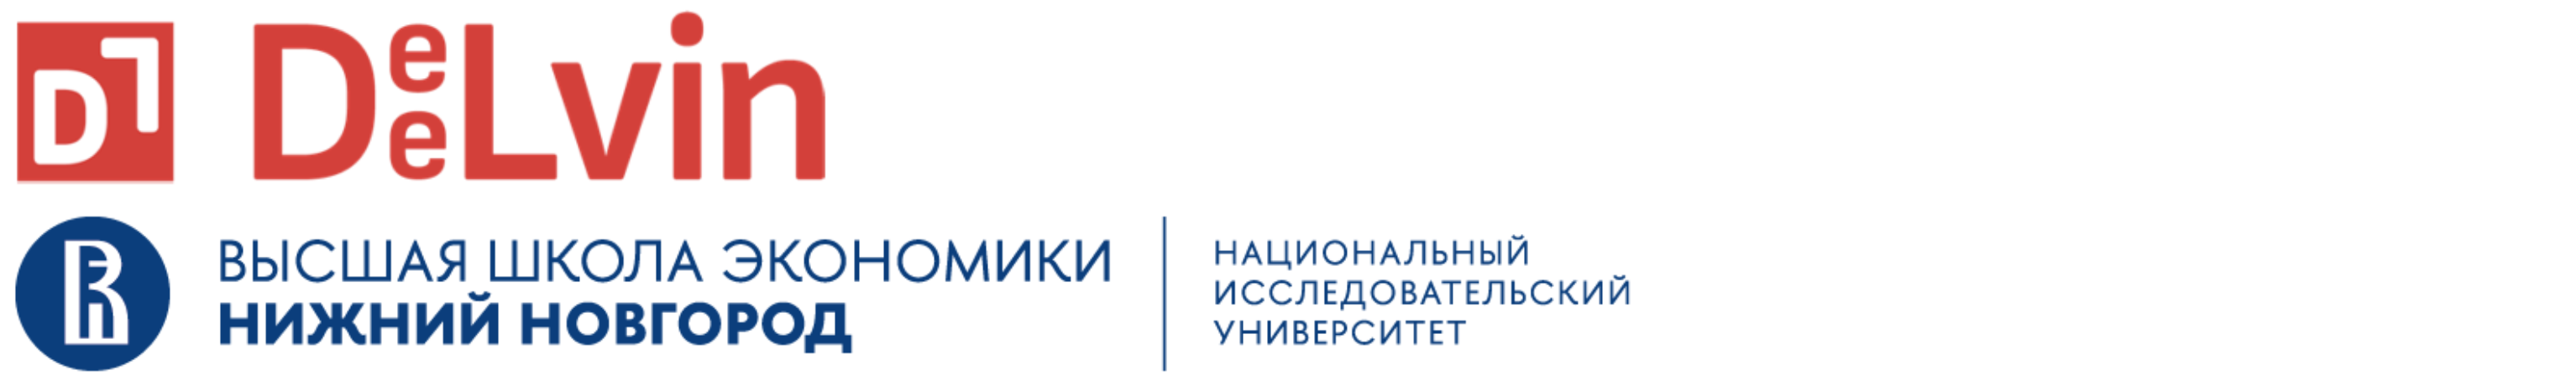

## Разбор домашнего задания

### Общие моменты
- **Q:** AutoTVM слишком долго ищет или же наоборот ничего не нашёл и всё стало хуже:
    - **A:** Если слишком долго, необходимо указать число триалов на которых надо запускать настройку или `early_stopping`, чтобы останавлиать поиск. Если ничего не нашёл или стало жухе, значит была проблема с параметрами - `early_stopping = 10` - не очень хорошая идея, т.к. если он за 10 триалов не нашёл хорошую конфигурацию, то заканчивает поиск. Таким образом у многих поиск остановился уже вначале.
- **Q:** Установка `TVM_NUM_THREADS` равным половине доступных ядер:
    - **A:** Лучше загружать машинку целиком, чтобы работа шла быстрее. На своей локальной машинке я ещё параллельно делал другие дела, поэтому её ресурсы мне были нужны и я установил только половину. Обычно лучше загрузить машину целеком и не трогать её.

- **Q:** Число триалов для Auto-Scheduler и Meta-Scheduler (у многих 512 и 513, а где-то и меньше):
    - **A:** В модели MNIST такие значения были выбраны, потому что из модели было извлечено $4$ задачи, за один раунд запускается $64$ триала. После каждого раунда cost модель обновляется и извлекаются новые задачи. Хотелось выбрать выбрать число триалов такое, чтобы у каждой из задач была возможность настраиваться 2 раунда: $4 \cdot 2 \cdot 64 = 512$. На самом деле можно было бы и больше указать, возможно, что что-то нашлось бы. Чем больше число триалов, тем больше конфигураций переберётся. Можно использовать `early_stopping` для завершения, но указав значение, например, 100 триалов. Все эти значения подбираются эмпирически.
- **Q:** Просмотр содержимого в моделях разных фреймворков:
    - **A:** https://netron.app/

### Мельников Андрей Александрович
- Большее число триалов для Auto-Scheduler причём, что интересно, для Meta-Scheduler уже большее значение и коррелирующее с числом задач.

### Андронов Сергей
- Собель - написан на керас и сконвертирован в TVM. Замеры тюнинга для собеля Meta-Scheduler быстрее, чем Auto-Scheduler. Собель только по Х.

### Алексанян Размик
- `"Сравниваем результаты (да, это дело должно упасть)"` стоит задавать некую точность сравнения, т.к. реализации могут отличаться и ошибка для чисел с плавающей точкой может накапливаться.
- `early_stopping`, я бы поставил значение побольше.
- Проблема с производительностью - малое пространство поиска, которое было использовано.
- `Можно ли тюнить конкретные слои?`. Для собеля же как раз это и было сделано или имеется ввиду, что из всей топологии настроить только часть задач? 
- `Auto-TVM имеет баг. По какой-то причине иногда он находит лишь 1 таск вместо 22, кучка экспериментов показала, что это дело будто рандомное. Есть идеи?`
- Собель только по Х, но на Relay.

### Румянцев Константин
- `early_stoping` - почти сразу тюнинг завершился, поэтому и плохое время.
- Малое число триалов у Auto-Scheduler.
- Meta-Scheduler - большее число триалов и уже появился прирост производительности.

### Волкова Екатерина
- Проблемы с импортёром кераса: 
    - Происходило расхождение по размерам для `conv2d_transpose`: https://github.com/apache/tvm/pull/13998
    - Не реализован слой `keras.layers.Rescaling`
- При настройке можно было большее число триалов указать.
- Собель:
    - Собель и по `x` и по `y`.
    - Умножение матриц не надо делать в свёртке. Число выходных каналов у свёртки должно быть $2$, там и будут значения для `x` и `y`. Затем уже можно будет `numpy` массивы перемножить.

## Пример реализации фильтра Собеля

In [ ]:
def get_filter(dtype="float32"):
    sobelv = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=dtype)
    sobelh = sobelv.transpose()
    sobel = np.array((sobelh, sobelv))
    sobel = np.expand_dims(sobel, axis=3)
    sobel = sobel.transpose(1, 2, 3, 0)
    return sobel

def get_model(input_shape, dtype="float32"):                          
    filter = get_filter(dtype)
    input = tvm.relay.var("input", shape=input_shape, dtype=dtype)
    weight = tvm.relay.var("weight", shape=filter.shape, dtype=dtype)
    D = relay.nn.conv2d(input, weight, padding=(1, 1), data_layout="NHWC", kernel_layout="HWIO", out_dtype=dtype)

    mod = relay.Function([input, weight], D)
    params = {       
        "weight": tvm.nd.array(filter)                                     
    }         
    return mod, params

## План лекции 

- [Сбор послойной статистики](#Сбор-послойной-статистики)
- [Оптимизация тензорных операций](#Оптимизация-тензорных-операций)
- [Кросс-компиляция и RPC](#Кросс-компиляция-и-RPC)
- [Оптимизация модели под мобильное устройство](#Оптимизация-модели-под-мобильное-устройство)
- [Интеграция TVM в Android приложение](#Интеграция-TVM-в-Android-приложение)

# Подготовка

## Перенесём некоторые изменения с прошлой лекции в этот ноутбук

- Установим сам TVM, на случай если почему-то не установили его на прошлой лекции:

In [1]:
!pip install apache-tvm

Если используете TVM собранный из исходного кода и прописываете `PYTHON_PATH`, то нет необходимости устанавливать TVM через pip.

- Установим количество потоков, которые может использовать TVM:

In [2]:
import multiprocessing
import os

# Set number of threads used for tuning based on the number of
# physical CPU cores on your machine.
num_threads = multiprocessing.cpu_count()
print("Num threads: ", int(num_threads/2))
os.environ["TVM_NUM_THREADS"] = str(int(num_threads/2))

Num threads:  8


Переносим код, который позволяет TVM использовать половину из доступных потоков на машине. Не даём использовать все, чтобы не загружать компьютер на 100%.

- Переносим с небольшими изменениями функцию для замера производительности:

In [3]:
def evaluate_performance(lib, dev, data, input_name, dtype="float32"):
    # upload parameters to device
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data)
    module.run()
    output = module.get_output(0).numpy()

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))
    return output

В функцию `evaluate_performance` добавили сохранение выходного результата из модели. И будем его использовать для сравнения точности. Таже добавлено указание устройства, чтобы можно было запускать модель не только на CPU.

- Перенесём функцию для запуска настройки модели:

In [4]:
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner

def run_tuning(
    tasks, measure_option, n_trials=333, tuner="gridsearch", early_stopping=None, log_filename="tuning.log"
):
    for i, task in enumerate(tasks):
        prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        # create tuner
        if tuner == "xgb" or tuner == "xgb-rank":
            tuner_obj = XGBTuner(task, loss_type="rank")
        elif tuner == "ga":
            tuner_obj = GATuner(task, pop_size=50)
        elif tuner == "random":
            tuner_obj = RandomTuner(task)
        elif tuner == "gridsearch":
            tuner_obj = GridSearchTuner(task)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        # do tuning
        tuner_obj.tune(
            n_trial=n_trials,
            early_stopping=early_stopping,
            measure_option=measure_option,
            callbacks=[
                autotvm.callback.progress_bar(n_trials, prefix=prefix),
                autotvm.callback.log_to_file(log_filename),
            ],
        )

Из небольших изменений лишь то, что параметр `n_trial` можно теперь определить, передав аргумент в функцию. Это сделано для того, чтобы можно было ограничить пространство поиска.

- Без каких-либо изменения переносим функцию для извлечения AutoTVM задач из модели:

In [5]:
# extract workloads from relay program
def extract_tasks(mod, target, params):
    print("Mod:")
    print(mod)
    print("Extract tasks...")
    tasks = autotvm.task.extract_from_program(
        mod, target=target, params=params
    )
    assert(len(tasks) > 0)
    for idx, task in enumerate(tasks):
        print("Task: %d,  workload: %s" % (idx, task.workload))
    return tasks

## Загрузим MNIST модель в TVM

- Загрузим Keras MNIST модель из предыдущей лекции:

In [6]:
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical

(_, _), (X_test, y_test) = mnist.load_data()
X_test = X_test.reshape(10000,28,28,1)
y_test = to_categorical(y_test)

model = keras.models.load_model("../Common/mnist_keras_model")

2023-02-15 12:57:44.818346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 12:57:51.339236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загружаем тестовые данные для набора MNIST. Тренировочные нам не нужны, т.к. в этой лекции мы ничего обучать не будем. Добавляем размерность канала в данные и преобразуем классы картинок к вектору категорий. Затем загружаем модель, которую обучили и сохранили на прошлой лекции.

- Импортируем модель в TVM:

In [7]:
import tvm
from tvm import relay

input_name = "input_input"
model_name = "my_mnist_model"

input_shape = [1, 28, 28, 1] # [batch, height, width, channels]
shape_dict = {input_name: input_shape}
tvm_mod, params = relay.frontend.from_keras(model, shape_dict, layout="NHWC")
print(tvm_mod)

def @main(%input_input: Tensor[(1, 28, 28, 1), float32], %v_param_1: Tensor[(3, 3, 1, 64), float32], %v_param_2: Tensor[(64), float32], %v_param_3: Tensor[(3, 3, 64, 32), float32], %v_param_4: Tensor[(32), float32], %v_param_5: Tensor[(10, 18432), float32], %v_param_6: Tensor[(10), float32]) {
  %0 = nn.conv2d(%input_input, %v_param_1, padding=[0, 0, 0, 0], channels=64, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  %1 = nn.bias_add(%0, %v_param_2, axis=-1);
  %2 = nn.relu(%1);
  %3 = nn.conv2d(%2, %v_param_3, padding=[0, 0, 0, 0], channels=32, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  %4 = nn.bias_add(%3, %v_param_4, axis=-1);
  %5 = nn.relu(%4);
  %6 = nn.batch_flatten(%5);
  %7 = nn.dense(%6, %v_param_5, units=10);
  %8 = nn.bias_add(%7, %v_param_6);
  nn.softmax(%8)
}



Загружаем в TVM модель и печатаем её Relay представление.

- Строим модель:

In [8]:
target = tvm.target.Target("llvm  -mcpu=core-avx2")
dev = tvm.cpu(0)

with tvm.transform.PassContext(opt_level=3):
    tvm_lib = relay.build(tvm_mod, target=target, params=params)

conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.


Указываем целевую архитектуру и устройство, на котором будет запущена наша модель и строим модуль.

- Проверяем, что модель работает:

In [9]:
from tvm.contrib import graph_executor
import numpy as np

module = graph_executor.GraphModule(tvm_lib["default"](dev))

out = []
for data in X_test[:10]:
    module.set_input(input_name, data.reshape(1, 28, 28, 1))
    module.run()
    out.append(module.get_output(0).numpy()[0])

print("Prediction: ", np.argmax(out, axis=1))
print("Labels:     ", np.argmax(y_test[:10], axis=1))

Prediction:  [7 2 1 0 4 1 4 9 5 9]
Labels:      [7 2 1 0 4 1 4 9 5 9]


Создаём GraphExecutor модуль и проверям точность загруженной модели.

# Сбор послойной статистики

Начнём с того, что не успели рассмотреть на прошлой лекции, обсудим то, каким образом можно оценить производительность модели и время работы отдельных слоёв.

## Получаем дополнительную информацию из библиотеки

- Получаем исходный код:

In [10]:
print(tvm_lib.get_lib().get_source())

; ModuleID = 'TVMMod'
source_filename = "TVMMod"
target datalayout = "e-m:o-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-apple-darwin22.1.0"

%0 = type { double }
%1 = type { ptr, %2, i32, %3, ptr, ptr, i64 }
%2 = type { i32, i32 }
%3 = type { i8, i8, i16 }
%4 = type { ptr, i32 }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused = type { ptr, ptr, ptr, ptr }
%closure_loop_parallel_i0.i1.fused = type { ptr, ptr }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.1 = type { ptr, ptr, ptr, ptr }
%closure_loop_parallel_i0.i1.fused.0 = type { ptr, ptr }

@__TVMAPISetLastError = linkonce dllexport local_unnamed_addr global ptr null, align 8
@__TVMBackendParallelLaunch = linkonce dllexport local_unnamed_addr global ptr null, align 8
@.str = private constant [88 x i8] c"Assert fail: num_args == 2, tvmgen_default_fused_nn_batch_flatten: num_args should be 2\00", align 1
@.str.1 = private constant [159 x i8] c"Assert fail: arg_p0_code == 3 or arg_p0_code ==

Прежде чем перейти к получению послойной статистики модели, хотелось бы показать ещё несколько возможностей, которые предоставляет TVM. Из построенной библиотеки мы можем извлечь исходный код программы с помощью вызова метода `get_source`. В данном случае сгенерированный код представляет собой LLVM IR представление для нашей модели. Если бы мы компилировали подель под GPU с использованием OpenCL, то вызвав этот метод можно было бы посмотреть исходный код сгенерированных OpenCL программ. Эта функциональность полезна, если мы хотим посмотреть на тот код, что будет исполняться во время запуска и попробовать найти неоптимальные места в нём.

- Получаем ассемблерное представление из `LLVMModule`:

In [11]:
print(tvm_lib.get_lib().get_source("asm"))

	.section	__TEXT,__text,regular,pure_instructions
	.build_version macos, 13, 0
	.section	__TEXT,__const
	.p2align	5
LCPI0_0:
	.quad	18432
	.quad	768
	.quad	32
	.quad	1
	.section	__TEXT,__literal16,16byte_literals
	.p2align	4
LCPI0_1:
	.byte	0
	.byte	72
	.byte	0
	.byte	0
	.byte	0
	.byte	0
	.byte	0
	.byte	0
	.byte	1
	.byte	0
	.byte	0
	.byte	0
	.byte	0
	.byte	0
	.byte	0
	.byte	0
	.section	__TEXT,__text,regular,pure_instructions
	.globl	_tvmgen_default_fused_nn_batch_flatten
	.p2align	4, 0x90
_tvmgen_default_fused_nn_batch_flatten:
Lfunc_begin0:
	.file	1 "." "main.tir"
	.loc	1 0 0
	.cfi_startproc
	pushq	%rax
	.cfi_def_cfa_offset 16
Ltmp0:
	cmpl	$2, %edx
	jne	LBB0_1
Ltmp1:
	movl	(%rsi), %eax
	cmpl	$13, %eax
	ja	LBB0_5
Ltmp2:
	movl	$8344, %ecx
Ltmp3:
	btl	%eax, %ecx
	jae	LBB0_5
Ltmp4:
	movl	4(%rsi), %eax
	cmpl	$13, %eax
	ja	LBB0_8
Ltmp5:
	movl	$8344, %ecx
	btl	%eax, %ecx
	jae	LBB0_8
Ltmp6:
	movq	(%rdi), %rdx
Ltmp7:
	cmpl	$4, 16(%rdx)
	jne	LBB0_10
Ltmp8:
	cmpb	$2, 20(%rdx)
	jne	LBB0_14
Ltmp9:

Кроме того, у некоторых из модулей мы можем получить и другие виды представления исходного кода, так, например, LLVM модуль может распечатать исходный код в виде ассемблера.

- Получаем описание графа из библиотеки:

In [12]:
print(tvm_lib.get_graph_json())

{
  "nodes": [
    {
      "op": "null", 
      "name": "input_input", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "p0", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "p1", 
      "inputs": []
    }, 
    {
      "op": "tvm_op", 
      "name": "tvmgen_default_fused_nn_conv2d_add_nn_relu", 
      "attrs": {
        "out_layout": "", 
        "flatten_data": "0", 
        "hash": "cb10cc75e4ac9979", 
        "kernel_layout": "HWIO", 
        "num_outputs": "1", 
        "data_layout": "NHWC", 
        "func_name": "tvmgen_default_fused_nn_conv2d_add_nn_relu", 
        "num_inputs": "3"
      }, 
      "inputs": [
        [
          0, 
          0, 
          0
        ], 
        [
          1, 
          0, 
          0
        ], 
        [
          2, 
          0, 
          0
        ]
      ]
    }, 
    {
      "op": "null", 
      "name": "p2", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "p3", 
      "inp

Ещё одна полезная возможность - это получить представление вычислительного графа. В этом графе содержится описание всех операций, содержащихся в моделе, их параметры, размерности и т.п. Это представление используется в GraphExecutor для определения порядка вычислений в модели. Подробнее про структуру графа можно почитать [здесь](https://tvm.apache.org/docs/arch/debugger.html#computational-graph).

## Исследование послойной статистики выполнения модели

- Добавим функцию, которая будет собирать и отображать информацию о послойной статистике:

In [13]:
from tvm.contrib.debugger import debug_executor

def collect_per_layer_stat(lib, device, json_graph=None):
    if json_graph is None:
        json_graph = lib.get_graph_json()
    debug_module = debug_executor.GraphModuleDebug(lib["debug_create"]("default", device), [device], json_graph, None)
    debug_module.run(number=10, repeat=3)

Для извлечения послойной статистики используется `debug_executor`. Для его использования необходимо, чтобы TVM был собран с CMake ключом `-DUSE_PROFILER=ON`. Для создания `GraphModuleDebug`, который как раз и отвечает за сбор послойной статистики, нам необходимо иметь json представление вычислительного графа. Поэтому если json граф не был передан в функцию, то извлекаем его из библиотеки с моделью. Затем создаём непосредственно `GraphModuleDebug`. И запускаем его 10 раз с 3 повторениями каждого из слоёв. После запуска будет распечатана послойная статистика для нашей модели, отсортированная в порядке от медленных функций к быстрым. Подробнее про `debug_executor` можно почитать [тут](https://tvm.apache.org/docs/arch/debugger.html#how-to-use-debugger).

## Конфигурация по умолчанию

- Соберём послойную статистику для того расписания, что используется по умолчанию:

In [14]:
print("Default mode:")
collect_per_layer_stat(tvm_lib, dev)

Default mode:
Node Name                                       Ops                                             Time(us)  Time(%)  Shape            Inputs  Outputs  Measurements(us)                
---------                                       ---                                             --------  -------  -----            ------  -------  ----------------                
tvmgen_default_fused_nn_conv2d_add_nn_relu_1    tvmgen_default_fused_nn_conv2d_add_nn_relu_1    1577.384  82.634   (1, 24, 24, 32)  3       1        [1654.651, 1556.007, 1521.494]  
tvmgen_default_fused_nn_conv2d_add_nn_relu      tvmgen_default_fused_nn_conv2d_add_nn_relu      283.294   14.841   (1, 26, 26, 64)  3       1        [301.111, 277.009, 271.761]     
tvmgen_default_fused_nn_contrib_dense_pack_add  tvmgen_default_fused_nn_contrib_dense_pack_add  44.816    2.348    (1, 10)          3       1        [47.347, 40.94, 46.161]         
tvmgen_default_fused_nn_softmax                 tvmgen_default_fused_nn_soft

[12:58:19] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #0 tvmgen_default_fused_nn_conv2d_add_nn_relu:
[12:58:19] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 301.111 us/iter
[12:58:19] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 277.009 us/iter
[12:58:19] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 2: 271.761 us/iter
[12:58:19] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #1 tvmgen_default_fused_nn_conv2d_add_nn_relu_1:
[12:58:19] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 1654.65 us/iter
[12:58:19] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 1

Результатом вывода debug executor является таблица со слоями модели, упорядоченными в порядке от более медленных к более быстрым. Кроме этого выводятся информационные сообщения из `graph_executor_debug.cc` о времени исполнения каждой из операций на разных повторениях. У нас значение `repeat` равно 3, поэтому выводится по 3 итерации на операцию. Их можно отключить во время компиляции TVM, установив соответствующий уровень логирования.

Рассмотрим подробнее полученную таблицу. В первой колонке выводится имя слоя, во второй - имя операции. В случае, если модель содержит несколько одинаковых слоёв, то имя слоя у них будет отличаться, а имя операции будет одинаковым. Затем выводятся время исполнения в микросекундах и время исполнения слоя в процентном соотношении с временем исполнения всей модели. В остальных колонках указаны размерность выходного слоя, число входов и выходов у модели и время в микросекундах для каждого из повторений. 

Как можно видеть, свёрточные слои занимают большую часть времени исполнения, в сравнении с другими слоями. Наибольшее время в $\approx 1.5$ мс занимает второй свёрточный слой, который выполняет свёртку из $(1, 26, 26, 64)$ в $(1, 24, 24, 32)$. 

Рассмотрим послойную статистику для моделей после настройки с помощью AutoTVM, Auto-Scheduler и Meta-Scheduler.

## Конфигурация из AutoTVM

- Применям статистику AutoTVM с прошлой лекции и получаем послойную статистику:

In [15]:
from tvm import autotvm

log_file = "../Common/%s.autotvm.log" % model_name
with autotvm.apply_history_best(log_file):
    print("Compile...")
    with tvm.transform.PassContext(opt_level=3):
        lib = relay.build(tvm_mod, target=target, params=params)

print("AutoTVM mode:")
collect_per_layer_stat(lib, dev)

Compile...


AutoTVM mode:
Node Name                                     Ops                                           Time(us)  Time(%)  Shape            Inputs  Outputs  Measurements(us)               
---------                                     ---                                           --------  -------  -----            ------  -------  ----------------               
tvmgen_default_fused_nn_conv2d_add_nn_relu_1  tvmgen_default_fused_nn_conv2d_add_nn_relu_1  1513.663  88.227   (1, 24, 24, 32)  3       1        [1544.609, 1498.51, 1497.869]  
tvmgen_default_fused_nn_conv2d_add_nn_relu    tvmgen_default_fused_nn_conv2d_add_nn_relu    187.868   10.95    (1, 26, 26, 64)  3       1        [189.988, 186.065, 187.549]    
tvmgen_default_fused_nn_dense_add             tvmgen_default_fused_nn_dense_add             10.391    0.606    (1, 10)          3       1        [8.881, 12.763, 9.528]         
tvmgen_default_fused_nn_softmax               tvmgen_default_fused_nn_softmax               1.904    

[12:58:41] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #0 tvmgen_default_fused_nn_conv2d_add_nn_relu:
[12:58:41] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 189.988 us/iter
[12:58:41] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 186.065 us/iter
[12:58:41] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 2: 187.549 us/iter
[12:58:41] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #1 tvmgen_default_fused_nn_conv2d_add_nn_relu_1:
[12:58:41] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 1544.61 us/iter
[12:58:41] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 1

В сообщении `WARNING:strategy:conv2d NHWC layout is not optimized for x86 with autotvm.` TVM говорит о том, что свёрточные слои не были оптимизированны с использованием AutoTVM, поэтому значительного улучшения производительности не следует ожидать. Однако, если посмотреть на общее время исполнения, то увидим небольшое ускорение $\approx 0.2$ мс. Это объясняется оптимизацией полносвязанного слоя, для которого конфигурация была реализована в AutoTVM.

## Конфигурация из Auto-Scheduler

- Применяем статистику Auto-Scheduler:

In [16]:
from tvm import auto_scheduler

log_file = "../Common/%s.auto-scheduler.log" % model_name
with auto_scheduler.ApplyHistoryBest(log_file):
    print("Compile...")
    with tvm.transform.PassContext(opt_level=3, config={"relay.backend.use_auto_scheduler": True}):
        lib = relay.build(tvm_mod, target=target, params=params)

print("Auto-Scheduler mode:")
collect_per_layer_stat(lib, dev)

Compile...
Auto-Scheduler mode:
Node Name                                     Ops                                           Time(us)  Time(%)  Shape            Inputs  Outputs  Measurements(us)             
---------                                     ---                                           --------  -------  -----            ------  -------  ----------------             
tvmgen_default_fused_nn_conv2d_add_nn_relu    tvmgen_default_fused_nn_conv2d_add_nn_relu    183.159   63.769   (1, 26, 26, 64)  3       1        [175.018, 200.702, 173.758]  
tvmgen_default_fused_nn_conv2d_add_nn_relu_1  tvmgen_default_fused_nn_conv2d_add_nn_relu_1  74.42     25.91    (1, 24, 24, 32)  3       1        [68.705, 79.787, 74.766]     
tvmgen_default_fused_nn_dense_add             tvmgen_default_fused_nn_dense_add             16.869    5.873    (1, 10)          3       1        [15.486, 18.865, 16.258]     
tvmgen_default_fused_nn_softmax               tvmgen_default_fused_nn_softmax               1

[12:59:10] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #0 tvmgen_default_fused_nn_conv2d_add_nn_relu:
[12:59:10] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 175.018 us/iter
[12:59:10] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 200.702 us/iter
[12:59:10] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 2: 173.758 us/iter
[12:59:10] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #1 tvmgen_default_fused_nn_conv2d_add_nn_relu_1:
[12:59:10] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 68.7054 us/iter
[12:59:10] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 7

Применив статистику Auto-Scheduler, наблюдаем значительный прирост производительности модели, т.к. свёрточные слои были оптимизированы.

## Конфигурация из Meta-Scheduler

- Применим статистику для Meta-Scheduler:

In [17]:
from tvm import meta_schedule as ms

strategy_name = "evolutionary"
work_dir = "../Common/{}_meta-scheduler_{}".format(model_name, strategy_name)
target_ms = tvm.target.Target("llvm -mcpu=core-avx2 -num-cores {}".format(int(num_threads/2)))

print("Compile...")
database = ms.database.JSONDatabase(f"{work_dir}/database_workload.json",
                                    f"{work_dir}/database_tuning_record.json",
                                    allow_missing=False)
with tvm.transform.PassContext(opt_level=3):
    lib = ms.relay_integration.compile_relay(database, tvm_mod, target_ms, params)
    
print("Meta-Scheduler mode:")
collect_per_layer_stat(lib, dev)

Compile...
Meta-Scheduler mode:
Node Name                                     Ops                                           Time(us)  Time(%)  Shape            Inputs  Outputs  Measurements(us)             
---------                                     ---                                           --------  -------  -----            ------  -------  ----------------             
tvmgen_default_fused_nn_conv2d_add_nn_relu    tvmgen_default_fused_nn_conv2d_add_nn_relu    155.898   46.383   (1, 26, 26, 64)  3       1        [160.087, 156.328, 151.278]  
tvmgen_default_fused_nn_conv2d_add_nn_relu_1  tvmgen_default_fused_nn_conv2d_add_nn_relu_1  148.547   44.196   (1, 24, 24, 32)  3       1        [133.017, 141.171, 171.454]  
tvmgen_default_fused_nn_dense_add             tvmgen_default_fused_nn_dense_add             26.843    7.986    (1, 10)          3       1        [20.143, 36.292, 24.095]     
tvmgen_default_fused_nn_softmax               tvmgen_default_fused_nn_softmax               2

[12:59:44] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #0 tvmgen_default_fused_nn_conv2d_add_nn_relu:
[12:59:44] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 160.087 us/iter
[12:59:44] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 156.328 us/iter
[12:59:44] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 2: 151.278 us/iter
[12:59:44] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:65: Op #1 tvmgen_default_fused_nn_conv2d_add_nn_relu_1:
[12:59:44] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 0: 133.017 us/iter
[12:59:44] /Users/echuraev/Workspace/OctoML/tvm/src/runtime/graph_executor/debug/graph_executor_debug.cc:68: Iteration: 1: 1

Для Meta-scheduler также получаем значительное ускорение модели. Цифры Auto-Scheduler и Meta-Scheduler очень близки и от запуска к запуску могут немного варьироваться так, что где-то Auto-Scheduler будет немного быстрее, а где-то Meta-Scheduler. Это объясняется погрешностью измерений, т.к. время исполнения очень маленькое и разница между настроенными моделями также очень не большая, то и время лучше то у одной, то у другой конфигурации.

## Сравнение результатов

- Обобщим и сравним полученные результаты в табличке:

| Название слоя                                | Default (ms) | AutoTVM (ms) | Auto-Scheduler (ms) | Meta-Scheduler (ms) |
|:---------------------------------------------|-------------:|-------------:|--------------------:|-------------------:|
| tvmgen_default_fused_nn_conv2d_add_nn_relu   | 0.2537       | 0.0765       | 0.1011              | 0.0975              |
| tvmgen_default_fused_nn_conv2d_add_nn_relu_1 | 1.5485       | 1.5712       | 0.0359              | 0.0417              |
| reshape_nop                                  | 0.0015       | 0.0016       | 0.0015              | 0.0014              |
| tvmgen_default_fused_nn_dense_add            | 0.0458       | 0.0115       | 0.0332              | 0.0139              |
| tvmgen_default_fused_nn_softmax              | 0.0016       | 0.0017       | 0.0093              | 0.002              |
| ---                                          |              |              |                     |                    |
| **Total**                                    | 1.8509       | 1.6625       | 0.1809              | 0.1564              |
| Performance                                  | 1.0          | 1.11         | 10.23               | 11,83              |


В таблице приведены результаты замеров времени работы слоёв для каждой из конфигураций построенной модели. Результаты в таблице могут немного отличаться от тех, что были получены во время запусков, т.к. таблица создавалась на этапе подготовки презентации во время первых запусков.

Слои в таблице отсортированы по порядку слоёв в модели. Так, первыми идут свёрточные слои, затем слой изменения формы, потом полносвязанный слой и, наконец, softmax. Всё время в таблице выражено в миллисекундах. Внизу таблицы приводится общее время выполнения модели и прирост производительности. За отправную точку выбрана конфигурация с расписанием по умолчанию. Так оптимизация полносвязанного слоя в AutoTVM даёт прирост производительности в $\approx 1.11$ раз, а оптимизированные модели после Auto-Scheduler и AutoTVM работают в $\approx 10$ и $\approx 11$ раз быстрее соответственно.

# Оптимизация тензорных операций

С помощью `debug_executor`, который рассматривался в предыдущем разделе, можно получить послойную статистику и оценить влияние времени одного слоя на производительность всей модели. В данном разделе рассмотрим, что необходимо сделать после обнаружения проблемного слоя.

## Подходы к оптимизации

- Оптимизация конфигураций расписания (AutoTVM/Meta-Scheduler)
- Реализация быстрой версии алгоритма
- Написание нового правила расписания (Auto-Scheduler/Meta-Scheduler)
- Добавление герерации вызовов низкоуровневых функций (интринсиков) или специальных типов для использования аппаратных возможностей архитектуры
- Добавление низкоуровневой библиотеки (DNNL, ACL, CLML, ...), оптимизированной для исполнения ML примитивов

Выше приведены некоторые из подходов, которые могут применяться для оптимизации времени выполнения модели. Рассмотрим каждый из них:
1. **<u>Оптимизация конфигураций расписания.</u>** Расписание для операции пишется вручную, зачастую может быть довольно сложным занятием, которое требует от разработчика знание аппаратного устройства целевой платформы. Бывает, что расписание не включает в себя оптимальную конфигурацию. Это может быть обусловлено сложностью разработки. Подробнее про написание расписания можно почитать [здесь](https://tvm.apache.org/docs/tutorial/tensor_expr_get_started.html), а про операции, применяемые при написании расписания - [тут](https://tvm.apache.org/docs/how_to/work_with_schedules/schedule_primitives.html).
2. **<u>Реализация быстрой версии алгоритма.</u>** Возможно, что вместо оптимизации расписания стоит написать новую реализацию алгоритма. Например, winograd реализация операции свёртки сокращает число вычислительных операци в [2.5 раза](https://medium.com/@dmangla3/understanding-winograd-fast-convolution-a75458744ff), и благодаря использованию нового алгоритма удастся достичь требуемой производительности.
3. **<u>Написание нового правила расписания.</u>** Новое правило может быть нацелено на автоматический поиск конфигурации, которая задействует эффективно целевое устройство, например, перебор значений, которые позволят максимально использовать векторные инструкции процессора. Подробнее про написание подобных правил можно почитать [здесь](https://tvm.apache.org/docs/how_to/tune_with_autoscheduler/tune_sparse_x86.html).
4. **<u>Изменение кодогенерации для целевого устройства.</u>** Ещё одним подходом является оптимизация платформозависимого кода, который генерирует TVM. Так, например, OpenCL предоставляет интринсик [mad](https://man.opencl.org/mad.html), который выполняет умножение двух величин и прибавляет к ним третье. Во время кодогенерации паттерны по типу $a \cdot b + c$ могут быть заменены на вызов одной функции `mad`. Или, например, устройства от Qualcomm с графическим чипом Adreno умеют эффективно работать с OpenCL типами `image2d_t`. `image2d_t` представляет собой объект, хранящий двухмерную матрицу и предоставляющий различные встроенные возможности для работы с изображениями, например, получение значения, которое находится между соседними пикселями. Добавление поддержки типов `image2d_t` позволило значительно улучшить производительность многих моделей на Adreno GPU.
5. **<u>Добавление низкоуровневой библиотеки.</u>** TVM позволяет использовать примитивы из различных низкоуровневых библиотек, эта технология называется BYOC (Bring Your Own Codegen). Разработчик может написать анализатор графа, который в случае, когда встретит операцию, которая может быть исполнена низкоуровневой библиотекой, выносит её в отдельный подграф, который во время исполнения будет вызывать примитивы из низкоуровневой библиотеки. Подробнее можно почитать по [сслыке](https://tvm.apache.org/docs/dev/how_to/relay_bring_your_own_codegen.html).

Далее мы рассмотрим первый подход - написание расписания вручную.

## Подготовка к оптимизации

- Функция, создающая модель с одним (наиболее медленным) слоем из нашей сети:

In [18]:
def get_model(input_shape, kernel_shape):     
    dtype = "float32"
    input = tvm.relay.var("input", shape=input_shape, dtype=dtype)
    weight = tvm.relay.var("weight", shape=kernel_shape, dtype=dtype)
    D = relay.nn.conv2d(input, weight, padding=[0, 0, 0, 0], channels=kernel_shape[-1], 
                        kernel_size=[kernel_shape[0], kernel_shape[1]], data_layout="NHWC", kernel_layout="HWIO")
                                                                          
    mod = relay.Function([input, weight], D)
    params = {       
        "weight": tvm.nd.array(np.random.uniform(-128, 127, kernel_shape).astype(dtype)),
    }         
    return mod, params

Для начала напишем простую функцию, которая будет создавать Relay представление наиболее медленного слоя из модели. Это удобно, т.к. не придётся тратить время на настройку всей модели и мы сможем локально наблюдать результат оптимизаций.

- Сгенерируем модель:

In [19]:
input_shape = (1, 26, 26, 64)
kernel_shape = (3, 3, 64, 32)

opt_mod, opt_params = get_model(input_shape, kernel_shape)
print(opt_mod)

fn (%input: Tensor[(1, 26, 26, 64), float32], %weight: Tensor[(3, 3, 64, 32), float32]) {
  nn.conv2d(%input, %weight, padding=[0, 0, 0, 0], channels=32, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO")
}


Устанавливаем размеры входного тензора и весов, передаём их в функцию и получаем Relay функцию.

- Построим модель:

In [20]:
with tvm.transform.PassContext(opt_level=3):
    opt_tvm_lib = relay.build(opt_mod, target=target, params=opt_params)

- Проинициализируем переменные, которые будут использовать в дальнейшем:

In [21]:
dtype = "float32"
data = tvm.nd.array(np.random.uniform(0, 255, input_shape).astype(dtype))
weights = opt_params["weight"]
out_shape = (1, 24, 24, 32)

В `dtype` храним тип данных, который используем в модели. Для входных данных случайным образом сгенерируем данные в диапазоне от 0 до 255 и сохраним их в переменную `data`. Веса возьмём из параметров модели, которые сгенерировали во время её создания и определим выходную размерность модели. Это нам понадобится чуть позже, при оценке эффективности расписания.

- Вызываем функцию для оценки производительности модели и сохраняем результат:

In [22]:
ref_output = evaluate_performance(opt_tvm_lib, dev, data, "input", dtype=dtype)

Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   0.1036       0.1064       0.1110       0.0933       0.0075   
               


Сохранённый результат затем будем использовать для оценки того, что точность модели не была поломана в процессе реализации функции вычислений и расписания.

## Приступаем к оптимизациям

- Подключаем необходимые модули:

In [23]:
from tvm import autotvm
from tvm import te, topi

- Реализуем шаблонную функцию для AutoTVM:

In [24]:
@autotvm.template("conv2d_nhwc_x86")
def conv2d_nhwc_x86(input_shape, kernel_shape, stride=[1, 1], padding=[0, 0, 0, 0], dilation=[1, 1], dtype="float32"):
    A = te.placeholder(input_shape, name="input", dtype=dtype)
    B = te.placeholder(kernel_shape, name="kernel", dtype=dtype)
    
    #conv = topi.nn.conv2d_nhwc(A, B, stride=stride, padding=padding, 
    #                           dilation=dilation, out_dtype=dtype)
    conv = conv2d_nhwc_x86_comp(A, B, stride, padding, dilation, dtype)
    
    s = te.create_schedule(conv.op)
    conv2d_nhwc_x86_schedule(s, conv)
    return s, [A, B, conv]

Обычно когда мы хотим расширить существующее расписание, то необходимо расширить стратегию для целевой платформы и добавить туда новые функции для вычислений и расписания. Подробнее об этом можно почитать [здесь](https://tvm.apache.org/docs/arch/relay_op_strategy.html). Однако из-за того, что мы оптимизируем эту функцию в образовательных целях и у нас, возможно, нет доступа к исходному коду TVM (например, мы установили TVM через pip), то будем использовать декоратор [autotvm.template](https://tvm.apache.org/docs/reference/api/python/autotvm.html#tvm.autotvm.task.task.template). Этот декоратор позволяет зарегистрировать функцию в AutoTVM и затем функция вычислений и расписание, определённые в рамках данной функции, будут использоваться во время тюнинга для поиска оптимальной конфигурации.

Набор параметров, которые принимает функция, соответствует списку значений, которые обычно принимает свёрточный слой. Затем создаём два placeholder'а, которые используются для замены входных тензеров во время описания функции вычислений и расписания.

В функции `conv2d_nhwc_x86_comp` будет описание вычислений на языке [TE](https://tvm.apache.org/docs/reference/api/python/te.html#tvm-te). Можно было бы использовать уже существующую реализацию, например, `topi.nn.conv2d_nhwc` и написать дла неё расписание, но для наглядности всего процесса разработки нового расписания напишем свою функцию для вычислений.

Затем создаём объект класса [Schedule](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Schedule), вызвав функцию [create_schedule](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.create_schedule) для последней операции из графа вычислений.

В функции `conv2d_nhwc_x86_schedule` позднее определим расписание для нашей операции свёртки. Из функции вернём класс расписания и список входных и выходных тензеров.

- Напишем функцию вычислений:

In [25]:
def conv2d_nhwc_x86_comp(data, weights, stride, padding, dilation, dtype):
    padded = topi.nn.pad(data, padding)
    KH, KW, IC, OC = weights.shape
    dilation_h, dilation_w = dilation
    dilated_kernel_h = (KH - 1) * dilation_h + 1
    dilated_kernel_w = (KH - 1) * dilation_w + 1
    stride_h, stride_w = stride
    N, H, W, C = data.shape
    PT, PL, PD, PR = padding
    OH = (H - KH + PT + PD) // stride_h + 1
    OW = (W - KW + PL + PR) // stride_w + 1
    
    rh = te.reduce_axis((0, KH), name="rh")
    rw = te.reduce_axis((0, KW), name="rw")
    rc = te.reduce_axis((0, IC), name="rc")
    conv = te.compute((N, OH, OW, OC),
        lambda n, h, w, c: te.sum(
            (
                padded[n, h * stride_h + rh * dilation_h, w * stride_w + rw * dilation_w, rc] 
                * weights[rh, rw, rc, c]
            ).astype(dtype),
            axis=[rh, rw, rc],
        ), name="conv2d_nhwc",
    )
    return conv

В функции вычислений определяем то, как должны происходить вычисления свёртки. Если необходимо понимание того, как происходит вычисление свёртки, то рекомендую посмотреть описания в интернете, например, [вот](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148). Не вдаваясь в подробности, разберём эту функцию вычислений:

1. Для начала добавляем отступ к входному тензору, если надо, с помощью операции `topi.nn.pad`.
2. Получаем размерности кернела, входных и выходных каналов из размера весов.
3. Вычисляем расширение (dilation) для кернела.
4. Получаем значение шага (stride) для кернела.
5. Получаем размеры входного тензора и отступов. Они будут использоваться для вычисления размера выходного тензора.
6. Вычисляем размеры выходного тензора:
   $$H_{out} = \dfrac{H_{in} - KH + Pad_{top} + Pad_{bottom}}{S_h + 1}$$
   $$W_{out} = \dfrac{W_{in} - KW + Pad_{left} + Pad_{right}}{S_w + 1}$$
   , где $H_{out}$ и $W_{out}$ - высота и ширина выходного тензора, $H_{in}$ и $W_{in}$ - высота и ширина данных на входе в свёртку, $KH$ и $KW$ - высота и ширина кернела, $Pad_{top/bottom/left/right}$ - отступ во входных данных сверху/снизу/слева/справа, $S_h$ и $S_w$ - шаг по высоте и ширине.
7. Определяем оси, по которым будем смещаться во время вычислений ($rh$ - по высоте кернела, $rw$ - по ширине и $rc$ - по входным каналам)
8. Определяем функцию, которая вычисляет свёртку по формуле:
   $$conv(n, h, w, c) = \sum_{rh=0}^{KH}\sum_{rw=0}^{KW}\sum_{rc=0}^{C_{in}}\left[padded(n, h \cdot S_h + rh \cdot D_h, w \cdot S_w + rw \cdot D_w, rc) \cdot kernel(rh, rw, rc, c)\right]$$
   , где $conv$ - результат свёртки, $n, h, w, c$ - координаты элемента в свёртке, $C_{in}$ - количество каналов во входном тензоре, $padded$ - входной тензор после добавления отступов, $D_h$ и $D_w$ - расширение по высоте и ширине.
   
В процессе оптимизаций функция вычислений не будет подвергаться больше никаким изменениям. В этом удобство TVM, что с помощью функции вычисления мы можем довольно легко выразить, как должна вычисляться операция, а затем с помощью операции расписания конечная реализация этой функции будет значительно изменена.

- Определим функцию расписания:

In [26]:
def conv2d_nhwc_x86_schedule(s, output):
    pass

На первом шаге не будем ничего добавлять в функцию расписания. Замерим её производительность и это будет для нас отправной точной в оптимизациях.

- Напечатаем TIR представление:

In [27]:
s, (A, B, conv) = conv2d_nhwc_x86(data.shape, weights.shape)
print(tvm.lower(s, [A, B, conv], simple_mode=True))

@main = primfn(input_1: handle, kernel_1: handle, conv2d_nhwc_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {input: Buffer(input_2: Pointer(float32), float32, [1, 26, 26, 64], []),
             kernel: Buffer(kernel_2: Pointer(float32), float32, [3, 3, 64, 32], []),
             conv2d_nhwc: Buffer(conv2d_nhwc_2: Pointer(float32), float32, [1, 24, 24, 32], [])}
  buffer_map = {input_1: input, kernel_1: kernel, conv2d_nhwc_1: conv2d_nhwc} {
  allocate(PadInput: Pointer(global float32), float32, [43264]), storage_scope = global {
    for (i1: int32, 0, 26) {
      for (i2: int32, 0, 26) {
        for (i3: int32, 0, 64) {
          let cse_var_1: int32 = (((i1*1664) + (i2*64)) + i3)
          PadInput_1: Buffer(PadInput, float32, [43264], [])[cse_var_1] = input_3: Buffer(input_2, float32, [43264], [])[cse_var_1]
        }
      }
    }
    for (h: int32, 0, 24) {
      for (w: int32, 0, 24) {
        for (c: int32, 0,

Получив расписание и список тензеров, можно, используя функцию [tvm.lower](https://tvm.apache.org/docs/reference/api/python/driver.html#tvm.lower), напечатать промежуточное тензорное представление функции, из этого представления будет генерироваться платформозависимый код. Таким образом, можно примерно представить, как программа будет исполняться на целевом устройстве.

В распечатанном представлении можно видеть аттрибуты функции, буфера, которые соответствуют входам и выходу функции. Затем идут две группы циклов. Первая группа отвечает за добавление отступов к входному тензору, вторая - за вычисление свёртки. Как можно видеть, код довольно прямолинейный и выражает ровно то, что мы описали в функции compute.

- Напишем небольшую функцию для замеров производительности расписания:

In [28]:
def run(func, data, weights, out_shape, dtype="float32"):
    out_array = tvm.nd.array(np.random.uniform(-1, 1, out_shape).astype(dtype))
    #func(data, weights, out_array)
    time_f = func.time_evaluator(func.entry_name, dev, number=100)
    cost = time_f(data, weights, out_array).mean
    print("%g ms\n" % (cost * 1000)) 
    return out_array.numpy()

Эта функция будет использоваться для замеров скорости работы расписания. Для начала необходимо создать `out_array` - это выходной тензор и из него можно будет получить результат работы функции. Если бы было необходимо только запустить фукнцию и не проводить замеры времени выполнения, то можно было бы это сделать, как представлено в закомментированной строчке, т.е. просто передав аргументы в функцию.

Для замеров производительности модуля можно использовать функцию [time_evaluator](https://tvm.apache.org/docs/reference/api/python/runtime.html#tvm.runtime.Module.time_evaluator), которая возвращает функтор, позволяющий получить время выполнения TVM модуля. Описывать параметры `time_evaluator` не будем, всё есть в официальной документации.

Вызвав функтор, получаем среднее время выполнения, выводим его на экран и возвращаем результат работы TVM модуля.

- Построим и запустим базовую реализацию:

In [29]:
func = tvm.build(s, [A, B, conv], target=target, name="conv")
output = run(func, data, weights, out_shape, dtype)

11.3962 ms



Выполняем построение расписания и запускаем его. На полученное время будем ориентироваться в процессе оптимизаций.

- Сравним результаты вычислений:

In [30]:
np.testing.assert_allclose(output, ref_output, rtol=1e-2, atol=1e-2)

Проверим, что реализованная функция вычислений показывает такую же точность, как и реализация из TVM.

## Добавляем параллелизм

- Обновим расписание и добавим параллелизм по выходным каналам:

In [31]:
def conv2d_nhwc_x86_schedule(s, output):
    conv = output
    n, h, w, c = conv.op.axis
    s[conv].parallel(c)

`output`, передаваемый в функцию расписания - это последний слой, т.е. свёртка. Поэтому обозначим `output` как `conv`, чтобы не путаться при написании расписания. Из `conv` получим оси, по которым происходят вычисления, и с помощью вызова [parallel](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Stage.parallel) укажем, что хотим добавить параллелизм по оси каналов.

- Распечатаем новое представление функции:

In [32]:
s, (A, B, conv) = conv2d_nhwc_x86(input_shape, kernel_shape)
print(tvm.lower(s, [A, B, conv], simple_mode=True))

@main = primfn(input_1: handle, kernel_1: handle, conv2d_nhwc_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {input: Buffer(input_2: Pointer(float32), float32, [1, 26, 26, 64], []),
             kernel: Buffer(kernel_2: Pointer(float32), float32, [3, 3, 64, 32], []),
             conv2d_nhwc: Buffer(conv2d_nhwc_2: Pointer(float32), float32, [1, 24, 24, 32], [])}
  buffer_map = {input_1: input, kernel_1: kernel, conv2d_nhwc_1: conv2d_nhwc} {
  allocate(PadInput: Pointer(global float32), float32, [43264]), storage_scope = global {
    for (i1: int32, 0, 26) {
      for (i2: int32, 0, 26) {
        for (i3: int32, 0, 64) {
          let cse_var_1: int32 = (((i1*1664) + (i2*64)) + i3)
          PadInput_1: Buffer(PadInput, float32, [43264], [])[cse_var_1] = input_3: Buffer(input_2, float32, [43264], [])[cse_var_1]
        }
      }
    }
    for (h: int32, 0, 24) {
      for (w: int32, 0, 24) {
        for (c: int32, 0,

Как можно видеть, у цикла с каналами появилось слово "parallel", указывающее, что этот цикл исполняется параллельно.

- Замерим время работы нового расписания:

In [33]:
func = tvm.build(s, [A, B, conv], target=target, name="conv")
_ = run(func, data, weights, out_shape, dtype)

3.08009 ms



Добавив параллелизм по каналам, удалось добиться ускорения почти в 4 раза. Продолжим модифицировать расписание.

## Добавим параллелизм по всем осям

- Добавим параллелизм по всем осям для отступов и свёртки:

In [34]:
def conv2d_nhwc_x86_schedule(s, output):
    conv = output
    pad_data, weights = conv.op.input_tensors
    pad_axes = s[pad_data].fuse(*pad_data.op.axis)
    s[pad_data].parallel(pad_axes)
    n, h, w, c = conv.op.axis
    conv_axes = s[conv].fuse(n, h, w, c)
    s[conv].parallel(conv_axes)

Используя `op.input_tensors`, можно получить входы для каждой из операций. Таким образом, у свёртки мы получаем на вход результат операции, которая добавляла отступ к входному тензору, и тензор с весами. Используя [fuse](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Stage.fuse), объединим все вычислительные оси для `pad_data` и `conv`, а затем добавим параллелизм по ним с помощью `parallel`. `fuse` просто объединяет все вычислительные циклы, которые в него были переданы в один цикл.

- Посмотрим на изменения:

In [35]:
s, (A, B, conv) = conv2d_nhwc_x86(input_shape, kernel_shape)
print(tvm.lower(s, [A, B, conv], simple_mode=True))

@main = primfn(input_1: handle, kernel_1: handle, conv2d_nhwc_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {input: Buffer(input_2: Pointer(float32), float32, [1, 26, 26, 64], []),
             kernel: Buffer(kernel_2: Pointer(float32), float32, [3, 3, 64, 32], []),
             conv2d_nhwc: Buffer(conv2d_nhwc_2: Pointer(float32), float32, [1, 24, 24, 32], [])}
  buffer_map = {input_1: input, kernel_1: kernel, conv2d_nhwc_1: conv2d_nhwc} {
  allocate(PadInput: Pointer(global float32), float32, [43264]), storage_scope = global {
    for (i0.i1.fused.i2.fused.i3.fused: int32, 0, 43264) "parallel" {
      PadInput_1: Buffer(PadInput, float32, [43264], [])[i0.i1.fused.i2.fused.i3.fused] = input_3: Buffer(input_2, float32, [43264], [])[i0.i1.fused.i2.fused.i3.fused]
    }
    for (n.h.fused.w.fused.c.fused: int32, 0, 18432) "parallel" {
      conv2d_nhwc_3: Buffer(conv2d_nhwc_2, float32, [18432], [])[n.h.fused.w.fused.c

Как можно видеть, вычислительные циклы для `pad_data` и `conv` объединились в один цикл и будут выполняться параллельно.

- Оценим время выполнения:

In [36]:
func = tvm.build(s, [A, B, conv], target=target, name="conv")
_ = run(func, data, weights, out_shape, dtype)

1.52259 ms



Добавление параллелизма по всем осям дало ещё ускорение почти в 2 раза, в сравнении с предыдущим расписанием. Основной вклад в ускорение даёт параллелизация вычислений `conv`, т.к. основные вычисления происходят в этом цикле. Параллелизм для `pad_data` практически не оказывает никакого влияния на общую производительность.

## Добавим векторизацию

- Обновим расписание и добавим векторизацию по каналам:

In [37]:
def conv2d_nhwc_x86_schedule(s, output):
    conv = output
    pad_data, weights = conv.op.input_tensors
    pad_axes = s[pad_data].fuse(*pad_data.op.axis)
    s[pad_data].parallel(pad_axes)
    n, h, w, c = conv.op.axis
    conv_axes = s[conv].fuse(n, h, w)
    s[conv].parallel(conv_axes)
    s[conv].vectorize(c)

Вместо того, чтобы делать параллелизм по всем размерностям `conv`, добавим векторизацию по каналам с помощью [vectorize](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Stage.vectorize). Это позволит нам считать несколько каналов одновременно за время одной инструкции. 

- Напечатаем новое расписание:

In [38]:
s, (A, B, conv) = conv2d_nhwc_x86(input_shape, kernel_shape)
print(tvm.lower(s, [A, B, conv], simple_mode=True))

@main = primfn(input_1: handle, kernel_1: handle, conv2d_nhwc_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {input: Buffer(input_2: Pointer(float32), float32, [1, 26, 26, 64], []),
             kernel: Buffer(kernel_2: Pointer(float32), float32, [3, 3, 64, 32], []),
             conv2d_nhwc: Buffer(conv2d_nhwc_2: Pointer(float32), float32, [1, 24, 24, 32], [])}
  buffer_map = {input_1: input, kernel_1: kernel, conv2d_nhwc_1: conv2d_nhwc} {
  allocate(PadInput: Pointer(global float32), float32, [43264]), storage_scope = global {
    for (i0.i1.fused.i2.fused.i3.fused: int32, 0, 43264) "parallel" {
      PadInput_1: Buffer(PadInput, float32, [43264], [])[i0.i1.fused.i2.fused.i3.fused] = input_3: Buffer(input_2, float32, [43264], [])[i0.i1.fused.i2.fused.i3.fused]
    }
    for (n.h.fused.w.fused: int32, 0, 576) "parallel" {
      conv2d_nhwc_3: Buffer(conv2d_nhwc_2, float32, [18432], [])[ramp((n.h.fused.w.fused*32), 

Как можно видеть, теперь при получении элементов из `conv2d_nhwc_3` используется функция `ramp` для подсчёта индекса. Она принимает `cse_var_1` - смещение, откуда нужно начинать считывать элементы, затем шаг и число элементов. Таким образом, добавив векторизацию, мы будем обрабатывать по 32 элемента единовременно.

- Замерим время выполнения:

In [39]:
func = tvm.build(s, [A, B, conv], target=target, name="conv")
_ = run(func, data, weights, out_shape, dtype)

0.0782724 ms



Добавив векторизацию, получили ускорение ещё почти в 15 раз в сравнении с предыдущим расписанием.

## Объединим внешние циклы и развернём внутренние

- Объединим цикл добавления отступов с циклом свёртки, переупорядочим и развернём внутренние циклы:

In [40]:
def conv2d_nhwc_x86_schedule(s, output):
    conv = output
    pad_data, weights = conv.op.input_tensors
    #pad_axes = s[pad_data].fuse(*pad_data.op.axis)
    #s[pad_data].parallel(pad_axes)
    s[pad_data].compute_inline()
    n, h, w, c = conv.op.axis
    conv_axes = s[conv].fuse(n, h, w)
    rh, rw, rc = s[conv].op.reduce_axis
    red = s[conv].fuse(rh, rw)
    s[conv].reorder(conv_axes, c, rc, red)
    s[conv].parallel(conv_axes)
    s[conv].vectorize(c)
    s[conv].unroll(red)

Как уже упоминалось ранее, операция `pad_data` практически не влияет на общее время выполнения слоя. С помощью [compute_inline](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Stage.compute_inline) можно объединить отдельные этапы расписания в один. Применив `compute_inline` для `pad_data`,  получение отступов будет выполняться непосредственно во время вычисления свёртки. В данном случае это никак не повлияет на конечный результат, иногда это может быть полезным, а иногда - приносить вред. Например, подобное добавление отступов в вычисления может принести в код дополнительные проверки (`if-else`), а при выполнении, когда на GPU есть различные ветвления в коде - это очень плохо и оказывает сильное влияние на производительность.

Кроме этого, используя [reduce_axis](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.reduce_axis) мы можем получить вложенные циклы `rh`, `rw` и `rc`, которые используются при вычислении свёртки. Самый большой из этих циклов - цикл по каналам `rc`. Используя [reorder](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Stage.reorder), переупорядочим циклы, чтобы большой цикл стал внешним, а остальные внутренними. С помощью функции `fuse` объединим циклы по ширине и высоте кернела в один, а затем, используя [unroll](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Stage.unroll), развернём этот цикл.

- Распечатаем представление

In [41]:
s, (A, B, conv) = conv2d_nhwc_x86(input_shape, kernel_shape)
print(tvm.lower(s, [A, B, conv], simple_mode=True))

@main = primfn(input_1: handle, kernel_1: handle, conv2d_nhwc_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {input: Buffer(input_2: Pointer(float32), float32, [1, 26, 26, 64], []),
             kernel: Buffer(kernel_2: Pointer(float32), float32, [3, 3, 64, 32], []),
             conv2d_nhwc: Buffer(conv2d_nhwc_2: Pointer(float32), float32, [1, 24, 24, 32], [])}
  buffer_map = {input_1: input, kernel_1: kernel, conv2d_nhwc_1: conv2d_nhwc} {
  for (n.h.fused.w.fused: int32, 0, 576) "parallel" {
    conv2d_nhwc_3: Buffer(conv2d_nhwc_2, float32, [18432], [])[ramp((n.h.fused.w.fused*32), 1, 32)] = broadcast(0f32, 32)
    for (rc: int32, 0, 64) {
      let cse_var_3: int32 = (rc*32)
      let cse_var_2: int32 = (n.h.fused.w.fused*32)
      let cse_var_1: int32 = (((floordiv(n.h.fused.w.fused, 24)*1664) + (floormod(n.h.fused.w.fused, 24)*64)) + rc)
       {
        conv2d_nhwc_3[ramp(cse_var_2, 1, 32)] = (conv2d_nhwc_3[ra

Как можно видеть, теперь остался только один глобальный цикл, который используется для вычисления конволюции. Он содержит один вложенный цикл по каналам входного тензора, а остальные вложенные циклы развернулись.

- Проведём замеры времени выполнения нового расписания:

In [42]:
func = tvm.build(s, [A, B, conv], target=target, name="conv")
_ = run(func, data, weights, out_shape, dtype)

0.0970488 ms



Добавленные изменения немного увеличили скорость выполнения слоя, но незначительно.

## Добавим правила для автоматического поиска оптимального расписания

- Обновим функцию расписания:

In [43]:
def conv2d_nhwc_x86_schedule(s, output):
    conv = output
    pad_data, weights = conv.op.input_tensors
    
    n, h, w, c = conv.op.axis
    rh, rw, rc = s[conv].op.reduce_axis
    
    cfg = autotvm.get_config()
    
    ## Define search space:
    cfg.define_knob("inline_pad", [False, True])
    cfg.define_knob("vec_size", [1, 4, 8, 16, 32, 64])
    cfg.define_annotate("red_try_unroll", [rh, rw, rc], policy="try_unroll")
    cfg.define_reorder("reorder", [rh, rw, rc], policy="all")
    
    if cfg["inline_pad"].val is True:
        s[pad_data].compute_inline()
    else:
        pad_axes = s[pad_data].fuse(*pad_data.op.axis)
        s[pad_data].parallel(pad_axes)
    
    co, ci = s[conv].split(c, cfg["vec_size"].val)
    conv_axes = s[conv].fuse(n, h, w, co)
    cfg["reorder"].apply(s, conv, [rh, rw, rc])
    cfg["red_try_unroll"].apply(s, conv, [rh, rw, rc])
    s[conv].parallel(conv_axes)
    s[conv].vectorize(ci)

Используя [get_config](https://tvm.apache.org/docs/reference/api/python/autotvm.html#tvm.autotvm.task.task.get_config), получаем текущую конфигурацию AutoTVM и добавляем туда новые просранства поиска. 

[define_knob](https://tvm.apache.org/docs/reference/api/python/autotvm.html#tvm.autotvm.task.space.ConfigSpace.define_knob) позволяет определить набор параметров, которые будут перебираться во время настройки. Таким образом, мы будем перебирать параметры `True` и `False` для указания того, надо ли встраивать вычисление отступа в цикл со свёрткой, а также различные размеры ширины вектора будут генерироваться для конфигураций поиска.

Используя [define_annotate](https://tvm.apache.org/docs/reference/api/python/autotvm.html#tvm.autotvm.task.space.ConfigSpace.define_annotate), обозначим оси, которые мы хотим попробовать развернуть. Это будут оси, по которым происходит суммирование результатов свёртки.

[define_reorder](https://tvm.apache.org/docs/reference/api/python/autotvm.html#tvm.autotvm.task.space.ConfigSpace.define_reorder) позволяет указать, что AutoTVM может переставлять вложенные циклы местами для поиска оптимальной конфигурации.

Затем применяем эти параметры поиска к расписанию. Ещё одна новая функция здесь - это [split](https://tvm.apache.org/docs/reference/api/python/te.html#tvm.te.Stage.split). `split` выполняет функцию обратную `fuse`, т.е. разбивает цикл. Используем операцию `split`, чтобы разбить подсчёты по выходным каналам на фактор, равный ширине вектора. Соответственно, внутренний цикл будем векторизовать, а внутренний объединим с другими осями, по которым происходит вычисление свёртки.

- Напечатаем новое расписание:

In [44]:
s, (A, B, conv) = conv2d_nhwc_x86(input_shape, kernel_shape)
print(tvm.lower(s, [A, B, conv], simple_mode=True))

@main = primfn(input_1: handle, kernel_1: handle, conv2d_nhwc_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {input: Buffer(input_2: Pointer(float32), float32, [1, 26, 26, 64], []),
             kernel: Buffer(kernel_2: Pointer(float32), float32, [3, 3, 64, 32], []),
             conv2d_nhwc: Buffer(conv2d_nhwc_2: Pointer(float32), float32, [1, 24, 24, 32], [])}
  buffer_map = {input_1: input, kernel_1: kernel, conv2d_nhwc_1: conv2d_nhwc} {
  allocate(PadInput: Pointer(global float32), float32, [43264]), storage_scope = global {
    for (i0.i1.fused.i2.fused.i3.fused: int32, 0, 43264) "parallel" {
      PadInput_1: Buffer(PadInput, float32, [43264], [])[i0.i1.fused.i2.fused.i3.fused] = input_3: Buffer(input_2, float32, [43264], [])[i0.i1.fused.i2.fused.i3.fused]
    }
    for (n.h.fused.w.fused.c.outer.fused: int32, 0, 18432) "parallel" {
      conv2d_nhwc_3: Buffer(conv2d_nhwc_2, float32, [18432], [])[n.h.fused.w.f

Как видим, сгенерированный код не содержит никаких оптимизаций за исключением тех, что применяются по умолчанию.

- Запустим новое расписание без настройки:

In [45]:
func = tvm.build(s, [A, B, conv], target=target, name="conv")
_ = run(func, data, weights, out_shape, dtype)

1.47813 ms



Время исполнения также далеко от оптимального.

- Создадим задачу поиска:

In [46]:
task = autotvm.task.create("conv2d_nhwc_x86", args=(input_shape, kernel_shape), target=target)
print(task.config_space)
tasks = [task]

ConfigSpace (len=576, range_length=576, space_map=
   0 inline_pad: OtherOption([False, True]) len=2
   1 vec_size: OtherOption([1, 4, 8, 16, 32, 64]) len=6
   2 red_try_unroll: Annotate(policy=try_unroll) len=8
   3 reorder: Reorder(policy=all) len=6
)


Используя функцию [create](https://tvm.apache.org/docs/reference/api/python/autotvm.html#tvm.autotvm.task.task.create), создадим задачу оптимизации для слоя. Из вывода видно, что пространство поиска влючает в себя 4 конфигурации, которые будут комбинироваться для поиска оптимального времени исполнения.

- Настроим параметры тюнинга и запустим настройку модели:

In [47]:
log_file = "conv2d_nhwc_x86.autotvm.log"
measure_option = autotvm.measure_option(
    builder=autotvm.LocalBuilder(),
    runner=autotvm.LocalRunner(repeat=10, enable_cpu_cache_flush=True),
)

run_tuning(tasks, measure_option, n_trials=len(task.config_space), tuner="xgb", log_filename=log_file)

[Task  1/ 1]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/576) | 0.00 s

/Users/echuraev/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2023-02-15 13:02:06.836 INFO Finish serving ('127.0.0.1', 58022)
2023-02-15 13:02:07.769 INFO Finish serving ('127.0.0.1', 58026)
2023-02-15 13:02:21.235 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpx0_znisg/tmp_func_560abf8d08a6fb6f.tar
2023-02-15 13:02:21.363 INFO Finish serving ('127.0.0.1', 58117)
2023-02-15 13:02:22.624 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmprtx_pc6v/tmp_func_1732c76894708b40.tar
2023-02-15 13:02:22.747 INFO Finish serving ('127.0.0.1', 58159)
2023-02-15 13:02:23.983 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmps0u07olj/tmp_func_c6110c4a8f93c742.tar
2023-02-15 13:02:24.112 INFO Finish serving ('127.0.0.1', 58192)
2023-02-

[Task  1/ 1]  Current/Best:  231.24/ 231.24 GFLOPS | Progress: (16/576) | 38.31 s

2023-02-15 13:02:42.085 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp1ayay135/tmp_func_d78196eae585983c.tar
2023-02-15 13:02:42.207 INFO Finish serving ('127.0.0.1', 58257)
2023-02-15 13:02:49.617 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpjbh_qa_d/tmp_func_e11568c551519501.tar
2023-02-15 13:02:49.800 INFO Finish serving ('127.0.0.1', 58274)
2023-02-15 13:02:51.030 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpp0djhkbu/tmp_func_b8f4a69371538cad.tar
2023-02-15 13:02:51.156 INFO Finish serving ('127.0.0.1', 58279)
2023-02-15 13:02:52.407 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmphd1p2_27/tmp_func_68e4d8bd8415cac4.tar
2023-02-15 13:02:52.528 INFO Finish serving ('127.0.0.1', 58290)
2023-02-15 13:02:53.739 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp6l__ue48/tmp_func_8d8111b02ed1887e.tar
2023-02-15 13:02:53.863 INFO Finish serving ('127.0.0.1', 58295)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  273.27/ 273.27 GFLOPS | Progress: (32/576) | 66.65 s

2023-02-15 13:03:10.424 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpa6imk0it/tmp_func_1f5080d31a4ab6e0.tar
2023-02-15 13:03:10.544 INFO Finish serving ('127.0.0.1', 58354)
2023-02-15 13:03:17.755 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0t54u5xz/tmp_func_81a126290ad99623.tar
2023-02-15 13:03:17.879 INFO Finish serving ('127.0.0.1', 58402)
2023-02-15 13:03:19.238 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpt5h2etc8/tmp_func_59f779a8863493a7.tar
2023-02-15 13:03:19.363 INFO Finish serving ('127.0.0.1', 58407)
2023-02-15 13:03:20.611 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp52hxp6g3/tmp_func_f3b5382e09b2e575.tar
2023-02-15 13:03:20.735 INFO Finish serving ('127.0.0.1', 58412)
2023-02-15 13:03:22.194 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpifgabmka/tmp_func_2248a9fa55f7278d.tar
2023-02-15 13:03:22.320 INFO Finish serving ('127.0.0.1', 58417)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  100.78/ 315.08 GFLOPS | Progress: (48/576) | 95.20 s

2023-02-15 13:03:38.967 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp4a9s_pae/tmp_func_53df155d43fd1b9b.tar
2023-02-15 13:03:39.094 INFO Finish serving ('127.0.0.1', 58480)
2023-02-15 13:03:46.731 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp1txnjc43/tmp_func_51902e3b66101419.tar
2023-02-15 13:03:46.913 INFO Finish serving ('127.0.0.1', 58549)
2023-02-15 13:03:48.350 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmppy195xgd/tmp_func_f3b30e16adbb7b71.tar
2023-02-15 13:03:48.469 INFO Finish serving ('127.0.0.1', 58554)
2023-02-15 13:03:49.710 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpxr5uoxy2/tmp_func_ab6cf54df852f7ce.tar
2023-02-15 13:03:49.846 INFO Finish serving ('127.0.0.1', 58559)
2023-02-15 13:03:51.121 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpgcsl2l6_/tmp_func_957330df434cf66a.tar
2023-02-15 13:03:51.245 INFO Finish serving ('127.0.0.1', 58565)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:   13.75/ 315.08 GFLOPS | Progress: (64/576) | 132.77 s

2023-02-15 13:04:23.598 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpgonpt7zw/tmp_func_707d929b092763bf.tar
2023-02-15 13:04:23.722 INFO Finish serving ('127.0.0.1', 58660)
2023-02-15 13:04:24.968 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpjqxjs0it/tmp_func_de3accb250452706.tar
2023-02-15 13:04:25.090 INFO Finish serving ('127.0.0.1', 58665)
2023-02-15 13:04:26.364 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpmlnbbblk/tmp_func_e6f83453111a12be.tar
2023-02-15 13:04:26.486 INFO Finish serving ('127.0.0.1', 58670)
2023-02-15 13:04:27.704 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp7iw6im84/tmp_func_146b10ca004a9aa0.tar
2023-02-15 13:04:27.828 INFO Finish serving ('127.0.0.1', 58675)
2023-02-15 13:04:29.098 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmprwpp36p3/tmp_func_a31adf2391ec3828.tar
2023-02-15 13:04:29.220 INFO Finish serving ('127.0.0.1', 58680)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  174.12/ 315.08 GFLOPS | Progress: (80/576) | 160.59 s

2023-02-15 13:04:44.357 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpelrjhtrv/tmp_func_a7a0f3d5331571fa.tar
2023-02-15 13:04:44.483 INFO Finish serving ('127.0.0.1', 58741)
2023-02-15 13:04:51.073 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpmdtpkk7l/tmp_func_ff8f523c3bf8ba2b.tar
2023-02-15 13:04:51.196 INFO Finish serving ('127.0.0.1', 58758)
2023-02-15 13:04:52.438 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp_pmwap7l/tmp_func_bd7dd7b12655d1d8.tar
2023-02-15 13:04:52.563 INFO Finish serving ('127.0.0.1', 58765)
2023-02-15 13:04:53.796 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp9mziywa7/tmp_func_b7cf9aa875dbefd7.tar
2023-02-15 13:04:53.920 INFO Finish serving ('127.0.0.1', 58769)
2023-02-15 13:04:55.161 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpzof4wf05/tmp_func_260410c1ee7d22a7.tar
2023-02-15 13:04:55.281 INFO Finish serving ('127.0.0.1', 58776)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  210.37/ 315.08 GFLOPS | Progress: (96/576) | 190.51 s

2023-02-15 13:05:14.282 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpth95rsku/tmp_func_e6c2b0f14c5150ea.tar
2023-02-15 13:05:14.405 INFO Finish serving ('127.0.0.1', 58849)
2023-02-15 13:05:22.422 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp2n5cnmko/tmp_func_c8fb8d52f067820f.tar
2023-02-15 13:05:22.545 INFO Finish serving ('127.0.0.1', 58870)
2023-02-15 13:05:24.079 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp6_puix0b/tmp_func_21c059f845efe8d6.tar
2023-02-15 13:05:24.198 INFO Finish serving ('127.0.0.1', 58875)
2023-02-15 13:05:25.600 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp6mr135zj/tmp_func_e1dd85b5fe9c55b4.tar
2023-02-15 13:05:25.724 INFO Finish serving ('127.0.0.1', 58880)
2023-02-15 13:05:27.066 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp3z1ie2u8/tmp_func_ab5074708dd2cfda.tar
2023-02-15 13:05:27.189 INFO Finish serving ('127.0.0.1', 58887)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  220.80/ 315.08 GFLOPS | Progress: (112/576) | 221.24 s

2023-02-15 13:05:45.008 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp7tx2gqae/tmp_func_d81c054be3e82b77.tar
2023-02-15 13:05:45.131 INFO Finish serving ('127.0.0.1', 58996)
2023-02-15 13:05:54.850 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp7uy91in3/tmp_func_6788f834cf554950.tar
2023-02-15 13:05:54.989 INFO Finish serving ('127.0.0.1', 59041)
2023-02-15 13:05:58.001 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp5gt_kpe5/tmp_func_caee0abd2e8aea67.tar
2023-02-15 13:05:58.148 INFO Finish serving ('127.0.0.1', 59097)
2023-02-15 13:06:01.672 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp1e_do3r6/tmp_func_64731e095fa1a94f.tar
2023-02-15 13:06:01.819 INFO Finish serving ('127.0.0.1', 59105)
2023-02-15 13:06:04.106 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp7_fqm2ue/tmp_func_16c826bb68a1ef35.tar
2023-02-15 13:06:04.252 INFO Finish serving ('127.0.0.1', 59161)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:   85.03/ 315.08 GFLOPS | Progress: (128/576) | 276.74 s

2023-02-15 13:06:50.178 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpaebmrkqy/tmp_func_faec2f84c7984a75.tar
2023-02-15 13:06:50.312 INFO Finish serving ('127.0.0.1', 59425)
2023-02-15 13:06:52.192 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmplexmwkgi/tmp_func_14b5acb27d9ec3f2.tar
2023-02-15 13:06:52.327 INFO Finish serving ('127.0.0.1', 59469)
2023-02-15 13:06:54.192 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpn5bxmnos/tmp_func_a6cef0881cb156c9.tar
2023-02-15 13:06:54.321 INFO Finish serving ('127.0.0.1', 59526)
2023-02-15 13:06:56.202 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmplr8xmn21/tmp_func_c433523da1f062aa.tar
2023-02-15 13:06:56.336 INFO Finish serving ('127.0.0.1', 59554)
2023-02-15 13:06:58.135 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmppm7_ucp7/tmp_func_72acf3bffbd5527d.tar
2023-02-15 13:06:58.267 INFO Finish serving ('127.0.0.1', 59559)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  236.67/ 315.08 GFLOPS | Progress: (144/576) | 313.82 s

2023-02-15 13:07:17.589 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0djzndg4/tmp_func_e06bb7634b350622.tar
2023-02-15 13:07:17.711 INFO Finish serving ('127.0.0.1', 59644)
2023-02-15 13:07:25.548 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp49k7gnae/tmp_func_e29755e95f77664f.tar
2023-02-15 13:07:25.667 INFO Finish serving ('127.0.0.1', 59707)
2023-02-15 13:07:26.894 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0m9_h32_/tmp_func_d6825f43f3ce5d65.tar
2023-02-15 13:07:27.022 INFO Finish serving ('127.0.0.1', 59713)
2023-02-15 13:07:28.292 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp599ek4xq/tmp_func_fdff9a2a6fcfa780.tar
2023-02-15 13:07:28.417 INFO Finish serving ('127.0.0.1', 59722)
2023-02-15 13:07:29.735 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpcvwoom4r/tmp_func_90a7fac30789cf46.tar
2023-02-15 13:07:29.861 INFO Finish serving ('127.0.0.1', 59726)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  164.97/ 315.08 GFLOPS | Progress: (160/576) | 343.39 s

2023-02-15 13:07:47.166 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpt4bvctyc/tmp_func_3a82ff1e44942ecf.tar
2023-02-15 13:07:47.286 INFO Finish serving ('127.0.0.1', 59805)
2023-02-15 13:07:55.534 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmparpp1f4s/tmp_func_7f0156eca2512212.tar
2023-02-15 13:07:55.657 INFO Finish serving ('127.0.0.1', 59838)
2023-02-15 13:07:57.079 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0t3tssz8/tmp_func_cb456ffbfb254be1.tar
2023-02-15 13:07:57.204 INFO Finish serving ('127.0.0.1', 59843)
2023-02-15 13:07:58.612 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmplreoq335/tmp_func_e2aed1118873c614.tar
2023-02-15 13:07:58.733 INFO Finish serving ('127.0.0.1', 59848)
2023-02-15 13:08:00.160 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpcg8f6x9u/tmp_func_70fa4825b9600425.tar
2023-02-15 13:08:00.282 INFO Finish serving ('127.0.0.1', 59853)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  147.05/ 315.08 GFLOPS | Progress: (176/576) | 375.68 s

2023-02-15 13:08:19.454 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp90h8stjv/tmp_func_62d2738202a41771.tar
2023-02-15 13:08:19.577 INFO Finish serving ('127.0.0.1', 59961)
2023-02-15 13:08:28.067 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpmm3w7lb8/tmp_func_33f13bccaa9011a0.tar
2023-02-15 13:08:28.192 INFO Finish serving ('127.0.0.1', 59981)
2023-02-15 13:08:29.743 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp67p9lgom/tmp_func_f051d9e660693d48.tar
2023-02-15 13:08:29.867 INFO Finish serving ('127.0.0.1', 59990)
2023-02-15 13:08:31.349 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0i_k259j/tmp_func_ed57105c6e726586.tar
2023-02-15 13:08:31.474 INFO Finish serving ('127.0.0.1', 59996)
2023-02-15 13:08:32.932 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpehb12dtw/tmp_func_3d749d16eb831bfa.tar
2023-02-15 13:08:33.060 INFO Finish serving ('127.0.0.1', 60005)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:   11.35/ 315.08 GFLOPS | Progress: (192/576) | 418.29 s

2023-02-15 13:09:06.904 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp9gzf9jcp/tmp_func_3def50410e885f40.tar
2023-02-15 13:09:07.032 INFO Finish serving ('127.0.0.1', 60149)
2023-02-15 13:09:08.767 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpuyvxr_mx/tmp_func_1357737de86607c6.tar
2023-02-15 13:09:08.893 INFO Finish serving ('127.0.0.1', 60154)
2023-02-15 13:09:10.819 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpypl73g3o/tmp_func_d6af49b00edc4ed3.tar
2023-02-15 13:09:10.946 INFO Finish serving ('127.0.0.1', 60160)
2023-02-15 13:09:12.780 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmplpl0sict/tmp_func_b089a7103a1ff7c2.tar
2023-02-15 13:09:12.902 INFO Finish serving ('127.0.0.1', 60166)
2023-02-15 13:09:14.638 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmptqio4zbj/tmp_func_90ee42fb35e0f53e.tar
2023-02-15 13:09:14.849 INFO Finish serving ('127.0.0.1', 60172)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:  132.49/ 315.08 GFLOPS | Progress: (208/576) | 451.80 s

2023-02-15 13:09:35.575 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpyy2s152c/tmp_func_7a67cd001629c910.tar
2023-02-15 13:09:35.697 INFO Finish serving ('127.0.0.1', 60238)
2023-02-15 13:09:45.287 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpgey3dq6q/tmp_func_9cc4eec2c7c6ff1b.tar
2023-02-15 13:09:45.416 INFO Finish serving ('127.0.0.1', 60258)
2023-02-15 13:09:48.113 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpzffynvi0/tmp_func_689c1a652b8ffc0b.tar
2023-02-15 13:09:48.241 INFO Finish serving ('127.0.0.1', 60264)
2023-02-15 13:09:50.015 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmppebv7vdq/tmp_func_c1492eb4e4aa0336.tar
2023-02-15 13:09:50.144 INFO Finish serving ('127.0.0.1', 60272)
2023-02-15 13:09:51.968 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpvxw3zlhr/tmp_func_37515378424df9a2.tar
2023-02-15 13:09:52.098 INFO Finish serving ('127.0.0.1', 60280)
2023-02-15 13:0

[Task  1/ 1]  Current/Best:   10.77/ 315.08 GFLOPS | Progress: (224/576) | 491.01 s

2023-02-15 13:10:25.036 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpqv_ftbup/tmp_func_680c407040c4cac0.tar
2023-02-15 13:10:25.180 INFO Finish serving ('127.0.0.1', 60374)
2023-02-15 13:10:26.897 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpzpkctc6q/tmp_func_830f19dee77fa174.tar
2023-02-15 13:10:27.033 INFO Finish serving ('127.0.0.1', 60388)
2023-02-15 13:10:28.741 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpsc0o3u9b/tmp_func_9a8f32b985fc48f0.tar
2023-02-15 13:10:28.875 INFO Finish serving ('127.0.0.1', 60394)
2023-02-15 13:10:30.556 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpwe14vegm/tmp_func_91471714565c9a1b.tar
2023-02-15 13:10:30.686 INFO Finish serving ('127.0.0.1', 60399)
2023-02-15 13:10:32.452 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp4pt9__uo/tmp_func_fdee4b1ce1676b9.tar
2023-02-15 13:10:32.585 INFO Finish serving ('127.0.0.1', 60405)
2023-02-15 13:10

[Task  1/ 1]  Current/Best:   11.36/ 315.08 GFLOPS | Progress: (240/576) | 528.77 s

2023-02-15 13:10:52.474 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpk9v0reff/tmp_func_5990078b5cabaf71.tar
2023-02-15 13:10:52.667 INFO Finish serving ('127.0.0.1', 60470)
2023-02-15 13:11:01.833 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp7z3bew9c/tmp_func_af5d49aec3750ea9.tar
2023-02-15 13:11:01.964 INFO Finish serving ('127.0.0.1', 60506)
2023-02-15 13:11:03.823 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0bd8rw3b/tmp_func_252f4c64ea867fe.tar
2023-02-15 13:11:03.968 INFO Finish serving ('127.0.0.1', 60513)
2023-02-15 13:11:05.693 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp_mjld_je/tmp_func_7548dc12386272da.tar
2023-02-15 13:11:05.839 INFO Finish serving ('127.0.0.1', 60526)
2023-02-15 13:11:07.748 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpj_3zba8o/tmp_func_e8fe3ede1cb20fdf.tar
2023-02-15 13:11:07.886 INFO Finish serving ('127.0.0.1', 60532)
2023-02-15 13:11

[Task  1/ 1]  Current/Best:   82.75/ 315.08 GFLOPS | Progress: (256/576) | 569.35 s

2023-02-15 13:11:40.775 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpll86u83h/tmp_func_bc7bda28012ca64c.tar
2023-02-15 13:11:40.898 INFO Finish serving ('127.0.0.1', 60709)
2023-02-15 13:11:42.468 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp435ybqde/tmp_func_1201abaaaeb99322.tar
2023-02-15 13:11:42.594 INFO Finish serving ('127.0.0.1', 60714)
2023-02-15 13:11:44.169 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpdorln6nq/tmp_func_7ebce4a5303c6534.tar
2023-02-15 13:11:44.299 INFO Finish serving ('127.0.0.1', 60719)
2023-02-15 13:11:45.896 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp_oc4eeoc/tmp_func_ce3b8e430239a74c.tar
2023-02-15 13:11:46.025 INFO Finish serving ('127.0.0.1', 60740)
2023-02-15 13:11:47.583 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmps3jidfwu/tmp_func_d07340fbbfc48263.tar
2023-02-15 13:11:47.705 INFO Finish serving ('127.0.0.1', 60745)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:  133.41/ 315.08 GFLOPS | Progress: (272/576) | 601.99 s

2023-02-15 13:12:05.762 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpfq_frvyi/tmp_func_51dd84d9ead492.tar
2023-02-15 13:12:05.889 INFO Finish serving ('127.0.0.1', 60920)
2023-02-15 13:12:16.642 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpq56k1pyx/tmp_func_69dbc6f503216479.tar
2023-02-15 13:12:16.771 INFO Finish serving ('127.0.0.1', 60977)
2023-02-15 13:12:18.570 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpxr6krajk/tmp_func_58d01d1b406ecbdc.tar
2023-02-15 13:12:18.700 INFO Finish serving ('127.0.0.1', 60997)
2023-02-15 13:12:20.519 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpn_0sdkcq/tmp_func_181309f65caec88c.tar
2023-02-15 13:12:20.645 INFO Finish serving ('127.0.0.1', 61035)
2023-02-15 13:12:22.497 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpba1gsol9/tmp_func_1b7777cc02f25c2.tar
2023-02-15 13:12:22.625 INFO Finish serving ('127.0.0.1', 61061)
2023-02-15 13:12:2

[Task  1/ 1]  Current/Best:   97.88/ 315.08 GFLOPS | Progress: (288/576) | 643.20 s

2023-02-15 13:12:46.965 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpz6l7tpxm/tmp_func_9208f5c6ae12b999.tar
2023-02-15 13:12:47.098 INFO Finish serving ('127.0.0.1', 61291)
2023-02-15 13:12:59.455 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0vihlbdw/tmp_func_2715bdf043ef9b18.tar
2023-02-15 13:12:59.592 INFO Finish serving ('127.0.0.1', 61370)
2023-02-15 13:13:02.498 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpaehpe7bg/tmp_func_f03d499cbb1bde75.tar
2023-02-15 13:13:02.634 INFO Finish serving ('127.0.0.1', 61376)
2023-02-15 13:13:05.361 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp1cazpvaa/tmp_func_f512f1d1c749c858.tar
2023-02-15 13:13:05.502 INFO Finish serving ('127.0.0.1', 61384)
2023-02-15 13:13:08.065 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpbvq_n0ic/tmp_func_b54b26f5498a6f51.tar
2023-02-15 13:13:08.199 INFO Finish serving ('127.0.0.1', 61392)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   96.10/ 315.08 GFLOPS | Progress: (304/576) | 671.83 s

2023-02-15 13:13:15.587 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp2m0snzo8/tmp_func_ddf392eb678f49f1.tar
2023-02-15 13:13:15.724 INFO Finish serving ('127.0.0.1', 61417)
2023-02-15 13:13:27.940 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpxjdsrfa1/tmp_func_6e7acaac3ee8244e.tar
2023-02-15 13:13:28.072 INFO Finish serving ('127.0.0.1', 61476)
2023-02-15 13:13:30.330 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpdft11ovd/tmp_func_eb6942056fc8a29a.tar
2023-02-15 13:13:30.488 INFO Finish serving ('127.0.0.1', 61486)
2023-02-15 13:13:32.824 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpn3ufz5kf/tmp_func_3487371feedff2b2.tar
2023-02-15 13:13:32.983 INFO Finish serving ('127.0.0.1', 61492)
2023-02-15 13:13:35.380 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpld821xa8/tmp_func_322c1bc781973a48.tar
2023-02-15 13:13:35.621 INFO Finish serving ('127.0.0.1', 61499)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   86.28/ 315.08 GFLOPS | Progress: (320/576) | 726.60 s

2023-02-15 13:14:22.573 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpt2kw51nj/tmp_func_cb7835cc2c788c13.tar
2023-02-15 13:14:22.707 INFO Finish serving ('127.0.0.1', 61704)
2023-02-15 13:14:24.716 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpzvy4xulb/tmp_func_985ac2f7ec468753.tar
2023-02-15 13:14:24.849 INFO Finish serving ('127.0.0.1', 61710)
2023-02-15 13:14:26.842 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpfus6_dqq/tmp_func_52207195d5df7448.tar
2023-02-15 13:14:26.976 INFO Finish serving ('127.0.0.1', 61716)
2023-02-15 13:14:28.910 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpdcz_v_69/tmp_func_a7953bbbfc373472.tar
2023-02-15 13:14:29.045 INFO Finish serving ('127.0.0.1', 61722)
2023-02-15 13:14:30.965 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp5cv6d76a/tmp_func_8141376ec1800898.tar
2023-02-15 13:14:31.184 INFO Finish serving ('127.0.0.1', 61727)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   42.07/ 315.08 GFLOPS | Progress: (336/576) | 759.96 s

2023-02-15 13:14:43.717 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmptrzipo7r/tmp_func_60ac8900d3e1dbb3.tar
2023-02-15 13:14:43.858 INFO Finish serving ('127.0.0.1', 61768)
2023-02-15 13:14:52.561 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpb2o_077p/tmp_func_776edfd4b33bba44.tar
2023-02-15 13:14:52.759 INFO Finish serving ('127.0.0.1', 61788)
2023-02-15 13:14:54.317 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpnb7nom3r/tmp_func_928027fdfb66d0f7.tar
2023-02-15 13:14:54.445 INFO Finish serving ('127.0.0.1', 61796)
2023-02-15 13:14:56.022 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpf3p8e3ij/tmp_func_47a4694cbdc1e869.tar
2023-02-15 13:14:56.147 INFO Finish serving ('127.0.0.1', 61801)
2023-02-15 13:14:57.747 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpu9rtc0tu/tmp_func_af33551daf391faa.tar
2023-02-15 13:14:57.872 INFO Finish serving ('127.0.0.1', 61807)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   46.38/ 315.08 GFLOPS | Progress: (352/576) | 794.19 s

2023-02-15 13:15:17.950 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpa9k_dglv/tmp_func_26106688ea5472df.tar
2023-02-15 13:15:18.088 INFO Finish serving ('127.0.0.1', 61874)
2023-02-15 13:15:26.816 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp8cwret3k/tmp_func_6fa1abf72d88b34b.tar
2023-02-15 13:15:27.009 INFO Finish serving ('127.0.0.1', 61902)
2023-02-15 13:15:28.457 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp3q0vvnp5/tmp_func_acced322b8d54438.tar
2023-02-15 13:15:28.586 INFO Finish serving ('127.0.0.1', 61911)
2023-02-15 13:15:30.035 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpf9cob6ou/tmp_func_44e8287380fc1b24.tar
2023-02-15 13:15:30.159 INFO Finish serving ('127.0.0.1', 61916)
2023-02-15 13:15:31.583 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpumhp5wy_/tmp_func_61035607e1d83df8.tar
2023-02-15 13:15:31.719 INFO Finish serving ('127.0.0.1', 61921)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   11.70/ 315.08 GFLOPS | Progress: (368/576) | 826.76 s

2023-02-15 13:15:50.461 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpirpaae94/tmp_func_7977962957f532cc.tar
2023-02-15 13:15:50.650 INFO Finish serving ('127.0.0.1', 62017)
2023-02-15 13:15:59.336 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpxtf7n7rp/tmp_func_4acae3e5b25a71d4.tar
2023-02-15 13:15:59.464 INFO Finish serving ('127.0.0.1', 62054)
2023-02-15 13:16:01.054 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp80k1s5ki/tmp_func_7e851daf7c5abea3.tar
2023-02-15 13:16:01.187 INFO Finish serving ('127.0.0.1', 62060)
2023-02-15 13:16:02.750 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpw7_ccz7r/tmp_func_f64883e6f8a655f6.tar
2023-02-15 13:16:02.882 INFO Finish serving ('127.0.0.1', 62081)
2023-02-15 13:16:04.473 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp94ct_y4k/tmp_func_54ffb68b45d5595a.tar
2023-02-15 13:16:04.605 INFO Finish serving ('127.0.0.1', 62085)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   22.34/ 315.08 GFLOPS | Progress: (384/576) | 864.60 s

2023-02-15 13:16:39.314 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmprpgb282a/tmp_func_8709e02e05a27a05.tar
2023-02-15 13:16:39.448 INFO Finish serving ('127.0.0.1', 62259)
2023-02-15 13:16:41.222 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp4foyt93x/tmp_func_d80894f2136cf106.tar
2023-02-15 13:16:41.348 INFO Finish serving ('127.0.0.1', 62265)
2023-02-15 13:16:43.055 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpsn6ttopv/tmp_func_bedb85b2cef06f14.tar
2023-02-15 13:16:43.185 INFO Finish serving ('127.0.0.1', 62273)
2023-02-15 13:16:44.862 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp2nsvpjkn/tmp_func_a0cbf4b2da12e47c.tar
2023-02-15 13:16:44.990 INFO Finish serving ('127.0.0.1', 62279)
2023-02-15 13:16:46.691 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpo4i6fz64/tmp_func_d92bbd340f03a737.tar
2023-02-15 13:16:46.818 INFO Finish serving ('127.0.0.1', 62282)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   45.81/ 315.08 GFLOPS | Progress: (400/576) | 901.82 s

2023-02-15 13:17:05.580 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpsxyvqjgk/tmp_func_cc009e3a84e24a0d.tar
2023-02-15 13:17:05.714 INFO Finish serving ('127.0.0.1', 62553)
2023-02-15 13:17:14.487 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpv8qvsgop/tmp_func_9ba74408a6a54e74.tar
2023-02-15 13:17:14.613 INFO Finish serving ('127.0.0.1', 62573)
2023-02-15 13:17:16.037 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpfzazok_e/tmp_func_8d2d5b520feffb49.tar
2023-02-15 13:17:16.172 INFO Finish serving ('127.0.0.1', 62579)
2023-02-15 13:17:17.600 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp15fhk2g9/tmp_func_55687ebca9985f9b.tar
2023-02-15 13:17:17.740 INFO Finish serving ('127.0.0.1', 62583)
2023-02-15 13:17:19.151 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmppbq43zko/tmp_func_f3fe47d5ce2f455e.tar
2023-02-15 13:17:19.286 INFO Finish serving ('127.0.0.1', 62589)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:  124.58/ 315.08 GFLOPS | Progress: (416/576) | 934.44 s

2023-02-15 13:17:38.209 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp210krueb/tmp_func_a2a8f01b13dfffba.tar
2023-02-15 13:17:38.337 INFO Finish serving ('127.0.0.1', 62690)
2023-02-15 13:17:46.515 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0zdpq2kh/tmp_func_3e6fb222b0bbf46a.tar
2023-02-15 13:17:46.651 INFO Finish serving ('127.0.0.1', 62708)
2023-02-15 13:17:48.163 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp0oohmcop/tmp_func_b1b4c43e921b204c.tar
2023-02-15 13:17:48.292 INFO Finish serving ('127.0.0.1', 62714)
2023-02-15 13:17:49.766 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpte6dycop/tmp_func_8bddc366e1a8387f.tar
2023-02-15 13:17:49.907 INFO Finish serving ('127.0.0.1', 62735)
2023-02-15 13:17:51.416 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpuy8320m0/tmp_func_37307ae2adc39e5a.tar
2023-02-15 13:17:51.613 INFO Finish serving ('127.0.0.1', 62741)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   46.47/ 315.08 GFLOPS | Progress: (432/576) | 969.92 s

2023-02-15 13:18:13.682 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpfogurbjt/tmp_func_c69cb6cb330765cc.tar
2023-02-15 13:18:13.817 INFO Finish serving ('127.0.0.1', 62814)
2023-02-15 13:18:23.075 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp2cg5ljhj/tmp_func_921ebdfbc59b2895.tar
2023-02-15 13:18:23.214 INFO Finish serving ('127.0.0.1', 62884)
2023-02-15 13:18:25.017 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpmtavdv_q/tmp_func_3e8d0a8a85f9a9b7.tar
2023-02-15 13:18:25.161 INFO Finish serving ('127.0.0.1', 62889)
2023-02-15 13:18:27.300 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpmcm6f_wy/tmp_func_f5a0b123efaca7.tar
2023-02-15 13:18:27.506 INFO Finish serving ('127.0.0.1', 62895)
2023-02-15 13:18:29.204 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpvunxyuv9/tmp_func_ad96b79882a05e60.tar
2023-02-15 13:18:29.336 INFO Finish serving ('127.0.0.1', 62902)
2023-02-15 13:18:

[Task  1/ 1]  Current/Best:   93.68/ 315.08 GFLOPS | Progress: (448/576) | 1012.43 s

2023-02-15 13:19:08.525 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp8q8j9if5/tmp_func_dd4e7ebb95ba5905.tar
2023-02-15 13:19:08.657 INFO Finish serving ('127.0.0.1', 63029)
2023-02-15 13:19:10.760 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmprwsix94y/tmp_func_44dc7b3b2ef2e520.tar
2023-02-15 13:19:10.891 INFO Finish serving ('127.0.0.1', 63036)
2023-02-15 13:19:12.872 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpjad8qg36/tmp_func_351eb0dd4f077dbd.tar
2023-02-15 13:19:13.005 INFO Finish serving ('127.0.0.1', 63042)
2023-02-15 13:19:14.967 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpikb30970/tmp_func_7355f1a57fa55ca.tar
2023-02-15 13:19:15.099 INFO Finish serving ('127.0.0.1', 63048)
2023-02-15 13:19:17.088 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmps_xtwzk2/tmp_func_ea58f76055afe51d.tar
2023-02-15 13:19:17.234 INFO Finish serving ('127.0.0.1', 63054)
2023-02-15 13:19

[Task  1/ 1]  Current/Best:   76.23/ 315.08 GFLOPS | Progress: (464/576) | 1043.83 s

2023-02-15 13:19:27.593 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp_xd4kb_t/tmp_func_14daf140b841249d.tar
2023-02-15 13:19:27.722 INFO Finish serving ('127.0.0.1', 63111)
2023-02-15 13:19:37.882 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmps_tzzqmw/tmp_func_361992826e12c6ed.tar
2023-02-15 13:19:38.089 INFO Finish serving ('127.0.0.1', 63135)
2023-02-15 13:19:39.706 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpmqlf07e9/tmp_func_ddc49586de7b33a8.tar
2023-02-15 13:19:39.848 INFO Finish serving ('127.0.0.1', 63147)
2023-02-15 13:19:41.564 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp67q0me04/tmp_func_f95a00867b65922c.tar
2023-02-15 13:19:41.698 INFO Finish serving ('127.0.0.1', 63152)
2023-02-15 13:19:43.320 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp2p5htvw8/tmp_func_bb92aed85188f159.tar
2023-02-15 13:19:43.527 INFO Finish serving ('127.0.0.1', 63158)
2023-02-15 13:1

[Task  1/ 1]  Current/Best:   46.25/ 315.08 GFLOPS | Progress: (480/576) | 1080.61 s

2023-02-15 13:20:04.356 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpnmgpk9h3/tmp_func_ffa009ce22fa7f.tar
2023-02-15 13:20:04.500 INFO Finish serving ('127.0.0.1', 63233)
2023-02-15 13:20:12.882 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmppt4l4dvw/tmp_func_40cc5a4eb0b92ac2.tar
2023-02-15 13:20:13.026 INFO Finish serving ('127.0.0.1', 63252)
2023-02-15 13:20:14.717 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp3ciub8l8/tmp_func_babeb9ec48d628c3.tar
2023-02-15 13:20:14.856 INFO Finish serving ('127.0.0.1', 63258)
2023-02-15 13:20:16.403 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpr19_u31m/tmp_func_4c8d2282145c12c6.tar
2023-02-15 13:20:16.606 INFO Finish serving ('127.0.0.1', 63265)
2023-02-15 13:20:18.117 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpfw06auvt/tmp_func_713d34dcd954aedf.tar
2023-02-15 13:20:18.244 INFO Finish serving ('127.0.0.1', 63271)
2023-02-15 13:20:

[Task  1/ 1]  Current/Best:   46.88/ 315.08 GFLOPS | Progress: (496/576) | 1114.94 s

2023-02-15 13:20:38.702 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpearmvtlk/tmp_func_577c830e28373066.tar
2023-02-15 13:20:38.836 INFO Finish serving ('127.0.0.1', 63335)
2023-02-15 13:20:47.482 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpeba54jyg/tmp_func_d856e469e348ad44.tar
2023-02-15 13:20:47.614 INFO Finish serving ('127.0.0.1', 63355)
2023-02-15 13:20:49.318 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpxrhubnjz/tmp_func_129577a1a14f976f.tar
2023-02-15 13:20:49.526 INFO Finish serving ('127.0.0.1', 63361)
2023-02-15 13:20:51.478 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpyc1tvrmf/tmp_func_8789f927f0bfb74e.tar
2023-02-15 13:20:51.609 INFO Finish serving ('127.0.0.1', 63367)
2023-02-15 13:20:53.377 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpcgsdkqcx/tmp_func_e999b9da15bde5f8.tar
2023-02-15 13:20:53.523 INFO Finish serving ('127.0.0.1', 63373)
2023-02-15 13:2

[Task  1/ 1]  Current/Best:   88.70/ 315.08 GFLOPS | Progress: (512/576) | 1155.20 s

2023-02-15 13:21:30.216 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpine9h6qc/tmp_func_676effe322b5fd4f.tar
2023-02-15 13:21:30.342 INFO Finish serving ('127.0.0.1', 63554)
2023-02-15 13:21:32.314 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpahu9yyhs/tmp_func_6f5a7c2bd0d9be32.tar
2023-02-15 13:21:32.446 INFO Finish serving ('127.0.0.1', 63567)
2023-02-15 13:21:34.425 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpke0l45an/tmp_func_6e4756e74bb8d1c9.tar
2023-02-15 13:21:34.556 INFO Finish serving ('127.0.0.1', 63574)
2023-02-15 13:21:36.894 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp43paew3x/tmp_func_f13aabb1f1c0d6c5.tar
2023-02-15 13:21:37.029 INFO Finish serving ('127.0.0.1', 63598)
2023-02-15 13:21:38.752 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp_xziluef/tmp_func_3bdcc819a60cdb9b.tar
2023-02-15 13:21:38.888 INFO Finish serving ('127.0.0.1', 63618)
2023-02-15 13:2

[Task  1/ 1]  Current/Best:   85.01/ 315.08 GFLOPS | Progress: (528/576) | 1195.68 s

2023-02-15 13:21:59.437 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmppm40vfxz/tmp_func_26337cbebddf65b.tar
2023-02-15 13:21:59.570 INFO Finish serving ('127.0.0.1', 63792)
2023-02-15 13:22:08.242 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpwm0yo4w5/tmp_func_8d46ba9840642464.tar
2023-02-15 13:22:08.388 INFO Finish serving ('127.0.0.1', 63836)
2023-02-15 13:22:10.055 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpnt4gucut/tmp_func_fa3026f414fa94a7.tar
2023-02-15 13:22:10.258 INFO Finish serving ('127.0.0.1', 63841)
2023-02-15 13:22:12.218 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmp18ivdkbb/tmp_func_c4b667e76f214144.tar
2023-02-15 13:22:12.359 INFO Finish serving ('127.0.0.1', 63864)
2023-02-15 13:22:14.116 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpoj0mg_5i/tmp_func_6f87915d75dad131.tar
2023-02-15 13:22:14.317 INFO Finish serving ('127.0.0.1', 63870)
2023-02-15 13:22

[Task  1/ 1]  Current/Best:   45.12/ 315.08 GFLOPS | Progress: (544/576) | 1231.04 s

2023-02-15 13:22:34.792 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpr0a95itz/tmp_func_c96dbc8f3edd7ecf.tar
2023-02-15 13:22:34.933 INFO Finish serving ('127.0.0.1', 64047)
2023-02-15 13:22:43.632 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpkkehfvpu/tmp_func_a08bfda3b1e4c466.tar
2023-02-15 13:22:43.779 INFO Finish serving ('127.0.0.1', 64073)
2023-02-15 13:22:45.282 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpwd0lgpd4/tmp_func_ea23bb25d0c4efba.tar
2023-02-15 13:22:45.426 INFO Finish serving ('127.0.0.1', 64079)
2023-02-15 13:22:47.015 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpx82jxo25/tmp_func_cef6531222da6fd6.tar
2023-02-15 13:22:47.160 INFO Finish serving ('127.0.0.1', 64084)
2023-02-15 13:22:49.109 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpqu6ys12c/tmp_func_b8d24601bb9efb18.tar
2023-02-15 13:22:49.254 INFO Finish serving ('127.0.0.1', 64088)
2023-02-15 13:2

[Task  1/ 1]  Current/Best:   44.67/ 315.08 GFLOPS | Progress: (560/576) | 1266.50 s

2023-02-15 13:23:10.255 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpbt2qnqrc/tmp_func_50471d4671991b13.tar
2023-02-15 13:23:10.398 INFO Finish serving ('127.0.0.1', 64179)
2023-02-15 13:23:19.260 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpfur_ym3g/tmp_func_11807ce85288c135.tar
2023-02-15 13:23:19.396 INFO Finish serving ('127.0.0.1', 64260)
2023-02-15 13:23:21.225 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpyohgnkwz/tmp_func_b44d0ef380471abb.tar
2023-02-15 13:23:21.373 INFO Finish serving ('127.0.0.1', 64264)
2023-02-15 13:23:22.984 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpesiztgyl/tmp_func_47175ab850b522e3.tar
2023-02-15 13:23:23.117 INFO Finish serving ('127.0.0.1', 64277)
2023-02-15 13:23:24.961 INFO load_module /var/folders/c1/cj1n52b57jd2t5g40sgrjx8r0000gn/T/tmpn4jpafr5/tmp_func_964f41d9a9ee0c45.tar
2023-02-15 13:23:25.107 INFO Finish serving ('127.0.0.1', 64292)
2023-02-15 13:2

[Task  1/ 1]  Current/Best:   47.45/ 315.08 GFLOPS | Progress: (576/576) | 1303.98 s Done.


- Распечатаем представление настроенной модели:

In [48]:
with autotvm.apply_history_best(log_file):
    with target:
        s, (A, B, conv) = conv2d_nhwc_x86(input_shape, kernel_shape)
print(tvm.lower(s, [A, B, conv], simple_mode=True))

@main = primfn(input_1: handle, kernel_1: handle, conv2d_nhwc_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {input: Buffer(input_2: Pointer(float32), float32, [1, 26, 26, 64], []),
             kernel: Buffer(kernel_2: Pointer(float32), float32, [3, 3, 64, 32], []),
             conv2d_nhwc: Buffer(conv2d_nhwc_2: Pointer(float32), float32, [1, 24, 24, 32], [])}
  buffer_map = {input_1: input, kernel_1: kernel, conv2d_nhwc_1: conv2d_nhwc} {
  for (n.h.fused.w.fused.c.outer.fused: int32, 0, 576) "parallel" {
    conv2d_nhwc_3: Buffer(conv2d_nhwc_2, float32, [18432], [])[ramp((n.h.fused.w.fused.c.outer.fused*32), 1, 32)] = broadcast(0f32, 32)
    for (rh: int32, 0, 3) {
      let cse_var_3: int32 = (rh*6144)
      let cse_var_2: int32 = (n.h.fused.w.fused.c.outer.fused*32)
      let cse_var_1: int32 = (((floordiv(n.h.fused.w.fused.c.outer.fused, 24)*1664) + (rh*1664)) + (floormod(n.h.fused.w.fused.c.outer.fused, 24)*6

Можно видеть, что после поиска оптимальной конфигурации с помощью AutoTVM, применилась векторизация по всем выходным каналам, а также все вложенные циклы развернулись. Потратив больше времени можно было бы задать больше параметров поиска для AutoTVM и возможно это позволило бы найти лучшую конфигурацию, однако главной целью было знакомство с инструментами, которые позволяют оптимизировать операторы в TVM. Поэтому остановимся на этом.

- Замерим время работы модели:

In [50]:
func = tvm.build(s, [A, B, conv], target=target, name="conv2d_nhwc_x86")
output = run(func, data, weights, out_shape, dtype)

0.0812616 ms



- Проверим, что точность осталась такой же:

In [51]:
np.testing.assert_allclose(output, ref_output, rtol=1e-2, atol=1e-2)

Время работы получилось немного лучше чем для расписания, которое используется в TVM по умолчанию, а точность осталась на том же уровне.

## Сравним с временем после настройки с помощью Auto-Scheduler

- Запустим слой, используя статистику, полученную на прошлой лекции:

In [81]:
log_file = "../Common/%s.auto-scheduler.log" % model_name

with auto_scheduler.ApplyHistoryBest(log_file):
    print("Compile...")
    with tvm.transform.PassContext(opt_level=3, config={"relay.backend.use_auto_scheduler": True}):
        opt_tvm_lib = relay.build(opt_mod, target=target, params=opt_params)

_ = evaluate_performance(opt_tvm_lib, dev, data, "input", dtype=dtype)

Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   0.0762       0.0765       0.0802       0.0720       0.0034   
               


Из-за того, что слой, который мы взяли для оптимизации, полностью соответствует слою из модели, которую тренировали на прошлой лекции, то можно применить статистику для той модели к этому слою. Во время сборки наилучшая конфигурация будет применена к функции вычисления. Время, полученное после применения статистики Auto-Scheduler, довольно близко к тому, что получилось после настройки нашего расписания с помощью AutoTVM. Значит, не смотря на цель научиться, а не получить максимальную производительность, расписание получилось не таким уж и плохим.

# Кросс-компиляция и RPC

## Что такое кросс-компиляция?

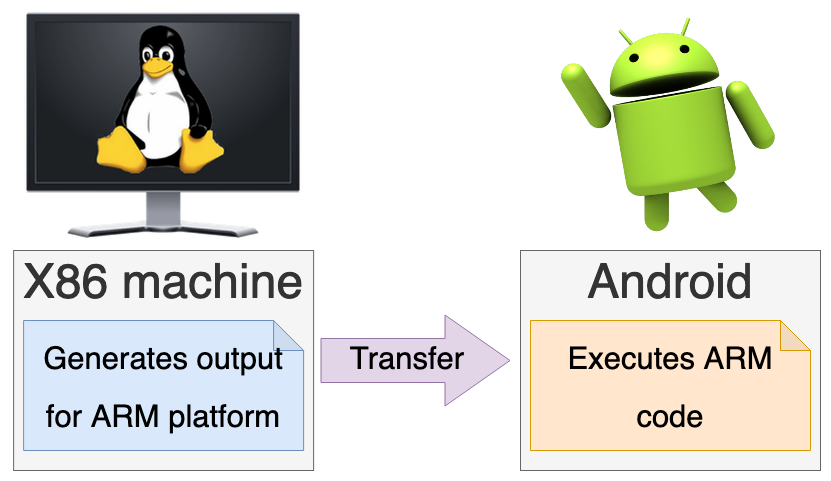

Кросс-компиляция - это компиляция программы для платформы с архитектурой отличной от той, на которой производится сборка. На рисунке выше приведён пример. На компьютере с x86 архитектурой нам необходимо скомпилировать программу для Android. Для этого используется компилятор, генерирующих машинный код для ARM архитектуры, затем полученный исполняемый файл отправляется на Android устройство и там может быть исполнен.

Такая компиляций бывает полезена, когда нужно получить код для платформы, экземпляров которой нет в наличии, или в случаях когда компиляция на целевой платформе невозможна или нецелесообразна (например, это касается мобильных систем или микроконтроллеров с минимальным объёмом памяти).

## Что такое RPC?

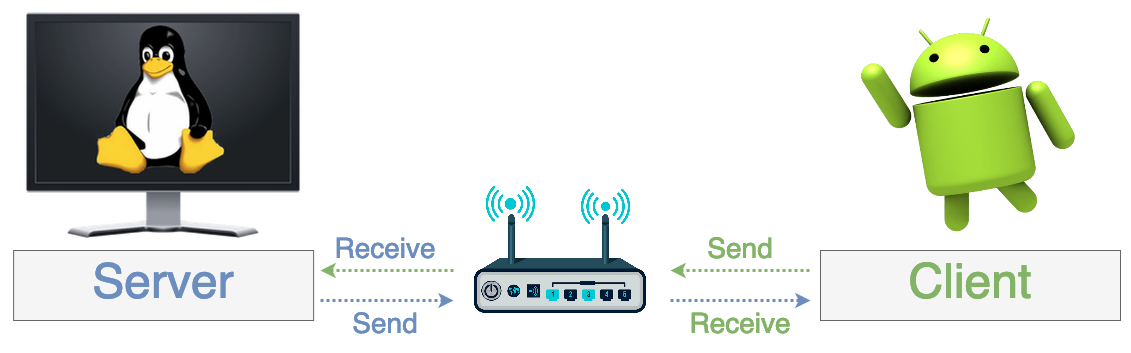

**Удаленный вызов процедур (Remote Procedure Call)** - это метод межпроцессного взаимодействия. Используется для клиент-серверных приложений. Механизмы RPC используются, когда компьютерная программа вызывает выполнение процедуры или подпрограммы в другом адресном пространстве, которое закодировано как обычный вызов процедуры, при этом программист специально не кодирует детали для удаленного взаимодействия. Другими словами - вызов метода или функции отправляется на удалённое устройство, там исполняется и возвращается в виде ответа назад. При этом в коде это выглядит как обычный вызов функции.

На рисунке выше приведён пример такого взаимодействия между сервером в виде стационарного компьютера и клиента в виде андроида. Клиент отправляет команду с андроида на сервер, там она выполняется и результат возвращается обратно клиенту.

## Зачем мне знать про кросс-компиляцию и RPC?

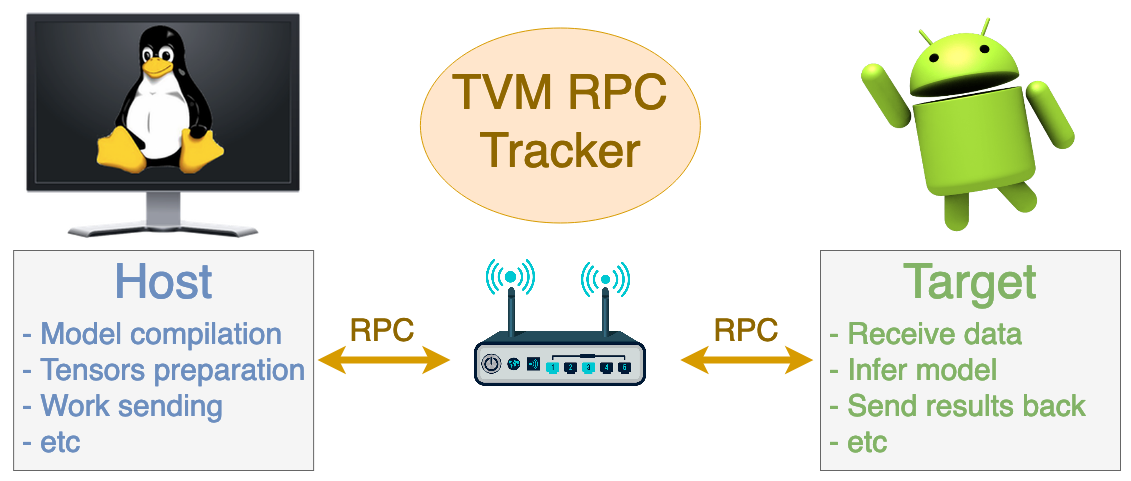

Технологии кросс-компиляции и RPC широко используются в TVM, когда есть необходимость запустить модель на каком-либо устройстве, например, Android смартфоне. Для запуска модели на целевом устройстве необходимо иметь библиотеку с TVM runtime, скомпилированную для этой платформы и RPC сервер. TVM runtime реализует основные функции TVM, необходимые для запуска модели, такие как работа с терзорами, запуск операторов, получение результата, замеры производительности и т.п. RPC сервер отвечает за коммуникацию получение команд с хоста и отправка ответов назад.

Зачастую скомпилировать TVM на целевом устройстве невозможно ввиду отсутствия компиляторов на устройстве или ограниченных аппаратных ресурсов, поэтому для сборки применяется кросс-компиляция. Таким образом в примере с Android устройством, TVM runtime и RPC сервер будут скомпилированны на хосте, затем их необходимо загрузить на телефон и уже там можно будет исполнять TVM модели.

Коммуникация между хостом и устройством происходит с помощью RPC. Обычно на хосте (однако, может также быть запущен на некоем 3-ем устройстве) запускается TVM RPC tracker. RPC tracker - это приложение в котором регистрируются RPC сервера и через него происходит общение между хостом и устройством. 

На рисунке выше приведена схема работы. К запущенному TVM RPC трекеру подключается RPC сервер, запущенный на Android и регистрирует устройство. Затем на хосте происходит обращение к трекеру с запросом получить целевое устройство с определённым ключом. Если устройство доступно, то хост и целевое устройство могут начать "общение" через TVM RPC Tracker, например, хост вызывает команду для запуска модели, эта команда транслируется в RPC Tracker, а тот в свою очередь передаёт её на устройство. Модель выполняется на целевом устройстве и результат и данные о запуске отправляются назад через RPC Tracker на хост.

Рассмотрим подробнее что нужно сделать, чтобы с помощью TVM запустить что-либо на удалённом устройстве.

## Кросс-компиляция TVM

- Выкачиваем исходный код TVM с github:
  ```bash
  git clone https://github.com/apache/tvm.git; cd tvm
  ```
- Обновляем и выкачиваем все подмодули:
  ```bash
  git submodule update --init --recursive
  ```
- Собираем TVM runtime для целевого устройства. В зависимости от устройства необходимо указать правильный компилятор:
  - Для сборки под Arduino описана здесь: https://tvm.apache.org/docs/tutorial/cross_compilation_and_rpc.html
  - RPC для iOS: https://github.com/apache/tvm/tree/main/apps/ios_rpc
  - RPC для Android: https://github.com/apache/tvm/tree/main/apps/android_rpc
  - Нативное RPC приложение: https://github.com/apache/tvm/tree/main/apps/cpp_rpc

Выше приведёр ряд ссылок, которые помогут разобраться в сборке TVM под конкретную платформу. 

В документации TVM приведён пример компиляции под различные микроконтроллеры, такие как Arduino и Firefly-RK3399. 

В репозитории на github также содержится ряд полезных приложений для запуска RPC на устройствах. Приложение `ios_rpc` предоставляет возможность запуска RPC сервера на устройствах от Apple. Также в документации к этому приложению подробно описан процесс построения TVM runtime для iOS. 

Для запуска моделей с использованием приложения Android RPC нет необходимости отдельно собирать TVM runtime, т.к. необходимые файлы с исходным кодом TVM собираются в момент сборки самого приложения, т.е. TVM runtime встроен в само приложение. Однако неудобство этого подхода заключается в том, что если необходимо добавить какой-либо модуль, который до этого не был включен в сборку, то необходимо его добавить в [заголовочный файл](https://github.com/apache/tvm/blob/main/apps/android_rpc/app/src/main/jni/tvm_runtime.h) и пересобрать приложение.

Приложение `cpp_rpc` может использоваться для запуска RPC сервера на любом другом устройстве. В инструкции на github приводится подробное описание того, как можно собрать это приложение для различных устройств и с различными TVM модулями. Мы также будем использовать это приложение для запуска RPC сервера на Android, т.к. оно работает стабильнее, в сравнении с Android RPC.

## Сборка cpp_rpc под Android

- Требования:
  - Android NDK: https://developer.android.com/ndk
  - Android Debug Bridge (ADB): https://developer.android.com/studio/command-line/adb
  - Поддержка OpenCL устройством (не обязательно)

- Собираем `cpp_rpc` и TVM runtime для Android:
  ```bash
  mkdir andorid_build && cd android_build
  cmake -DCMAKE_TOOLCHAIN_FILE=${ANDROID_NDK_HOME}/build/cmake/android.toolchain.cmake -DANDROID_ABI=arm64-v8a -DANDROID_NATIVE_API_LEVEL=android-28 -DANDROID_STL=c++_static -DUSE_CPP_RPC=ON ..
  make -j4 tvm_runtime tvm_rpc
  ```
- Для сборки с поддержкой OpenCL: `-DUSE_OPENCL=ON`

Для сборки `cpp_rpc` под Android потребуется установленный на компьютере Android NDK для сборки самого приложения и TVM Runtime, а также настроенный `adb` для взаимодействия со смартфоном, подключенным к компьютеру. Если планируется запускать модель на GPU, то необходиммо, чтобы устройство имело поддержку OpenCL. Однако, если OpenCL не поддерживается устройством, то можно запускать модель на CPU.

Если все требования выполнены, то можно приступать к сборке. Создаём директорию `android_build` и переходим туда. Затем конфигурируем сборку, указывая файл настраивает необходимые для сборки инструменты (toolchain). Этот файл находится в директории с NDK. Указываем под какую архитектуру и для какого Android API будет собираться приложение. Также статически линкуем c++ библиотеу. Ключ `-DUSE_CPP_RPC=ON` указывает, что кроме `tvm_runtime` необходимо собрать и `cpp_rpc`.

В случае если мы хотим использовать GPU, то в команду для CMake необходимо передать параметр `-DUSE_OPENCL=ON` указывая, что хотим собрать TVM runtime с поддержкой OpenCL. 

Затем можно приступать к сборке. Вызываем команду `make`, передавая в параметр `-j` число потоков, которые хотим использовать для сборки. Выше - это 4 потока. И пишем имена таргетов для сборки: `tvm_runtime` - сама библиотека с TVM runtime и `tvm_rpc` - это приложение `cpp_rpc`.

## Запуск cpp_rpc на устройстве

- Подключаем Android устройство к компьютеру. Используем `adb devices` для проверки, что устройство было успешно подключено.
- Загружаем TVM Runtime и `cpp_rpc` на устройство: `adb push {libtvm_runtime.so,tvm_rpc} /data/local/tmp`
- Проверяем, что приложение запустится: `adb shell "cd /data/local/tmp; LD_LIBRARY_PATH=/data/local/tmp /data/local/tmp/tvm_rpc"`.
- В консоли будет что-то подобное:
  ```
   server       - Start the server
  --host        - The hostname of the server, Default=0.0.0.0
  --port        - The port of the RPC, Default=9090
  --port-end    - The end search port of the RPC, Default=9099
  --tracker     - The RPC tracker address in host:port format e.g. 10.1.1.2:9190 Default=""
  --key         - The key used to identify the device type in tracker. Default=""
  --custom-addr - Custom IP Address to Report to RPC Tracker. Default=""
  --work-dir    - Custom work directory. Default=""
  --silent      - Whether to run in silent mode. Default=False

    Example
    ./tvm_rpc server --host=0.0.0.0 --port=9000 --port-end=9090  --tracker=127.0.0.1:9190 --key=rasp
  ```


В случае, если во время запуска приложение не распечатало подобное сообщение, то что-то пошло не так. Если вы увидели сообщение о том, что `libc++_shared.so` не может быть найдена на устройстве, то необходимо загрузить её на устройство вместе с TVM runtime и `cpp_rpc`. 

Для этого в директории с NDK ищем эту библиотеку для архитектуры целевого устройства:
```bash
find ${ANDROID_NDK_HOME} -name libc++_shared.so
```
Затем загружаем найденую библиотеку на смартфон:
```bash
adb push path/to/libc++_shared.so /data/local/tmp
```

Если во время запуска `tvm_rpc` выдаёт сообщение о том, что некорректный формат исполняемого файла, то это означает, что вы собрали `cpp_rpc` не для той архитектуры. Возможно надо изменить значение параметра `-DANDROID_ABI` при сборке TVM Runtime или использовать другой тулчейн.

## Настройка RPC соединения

- Запускаем RPC tracker: 
  ```bash
  python3 -m tvm.exec.rpc_tracker --host 0.0.0.0 --port 9190
  ```
- Проверяем состояние трекера:

In [52]:
!python3 -m tvm.exec.query_rpc_tracker --port 9190

Tracker address 0.0.0.0:9190

Server List
------------------------------
server-address           key
------------------------------
------------------------------

Queue Status
-------------------------------
key       total  free  pending
-------------------------------
-------------------------------



Для того, чтобы команды `tvm.exec.rpc_tracker` и `tvm.exec.query_rpc_tracker` отработали, необходимо прописать модули Python в `PYTHON_PATH`. Как это необходимо сделать было описано на предыдущей лекции, в разделе _"Сборка TVM из исходного кода. Установка TVM модуля в Python"_, либо можно установить TVM через pip.

Команда `query_rpc_tracker` возвращает список устройств, подключенных к трекеру. Т.к. ничего ещё не было подключено, то он пуст.

- Запускаем `tvm_rpc` на устройстве:
  ```bash
  adb reverse tcp:9190 tcp:9190
  adb forward tcp:9090 tcp:9090
  adb forward tcp:9091 tcp:9091
  adb forward tcp:9092 tcp:9092
  adb forward tcp:9093 tcp:9093
  adb shell LD_LIBRARY_PATH=/data/local/tmp /data/local/tmp/tvm_rpc server --host=0.0.0.0 --port=9090 --tracker=127.0.0.1:9190 --key=android --port-end=9190
  ```

Указание `reverse` и `forward` портов можно пропустить, если мобильное устройство и компьютер подключены к одной локальной сети. `reverse` и `forward` необходимы для пробрасывания портов через USB кабель. Тогда требование о нахождении устройтсв в одной сети уже не обязательно. И телефон, например, даже может не быть подключен к сети Wi-Fi. Указываем несколько `forward` портов, т.к. в случае неудачного отключения устройство может не отпустить его, но при этом RPC сервер уже переключится на следующий порт. В таком случае устройство может не принимать команды от `rpc_tracker`. Чтобы избежать подобной ситуации, сразу пробросим набор последовательных портов.

При запуске `tvm_rpc` необходимо прописать `LD_LIBRARY_PATH` - это путь, где динамический загрузчик будет искать библиотеки для приложения. У нас в этой директории лежит `libtvm_runtime.so`. Опишем параметры, которые передаются в `tvm_rpc`:
- `server` - указывает, что необходимо запустить RPC сервер на устройстве.
- `host` - адрес хоста на котором запускается сервер. `0.0.0.0` означает, что сервер запускается локально.
- `port` - порт на котором должен быть запущен RPC сервер.
- `tracker` - адрес и порт RPC трекера.
- `key` - имя, под которым устройтсво будет зарегистрировано в трекере.
- `port-end` - в случае если на `port` не удаётся запустить RPC сервер, например, порт занят, то `tvm_rpc` будет выполнять поиск свободного порта до значения, определённого в `port-end`.

После успешной сборки `rvm_rpc` можно приступить к запуску модели через RPC.

- Проверяем, что устройство было зарегистрировано в трекере:

In [53]:
!python3 -m tvm.exec.query_rpc_tracker --port 9190

Tracker address 0.0.0.0:9190

Server List
------------------------------
server-address           key
------------------------------
       127.0.0.1:9090    server:android
------------------------------

Queue Status
-------------------------------
key       total  free  pending
-------------------------------
android   1      1     0      
-------------------------------



## Запуск модели на устройстве через RPC

- Подключаем необходимые модули:

In [54]:
from tvm import rpc 
from tvm.contrib import utils, ndk

- Конфигурируем таргет под который будем собирать модель:

In [55]:
all_android_targets = {
    "armeabi-v7a": "llvm -mtriple=armv7a-linux-androideabi",
    "arm64-v8a": "llvm -mtriple=aarch64-linux-android",
    "x86": "llvm -mtriple=i686-linux-android",
    "x86_64": "llvm -mtriple=x86_64-linux-android",
}
target = tvm.target.Target(all_android_targets["arm64-v8a"])

USE_GPU = None
if USE_GPU == "GPU":
    target = tvm.target.Target("opencl", host=target)
elif USE_GPU == "ADRENO":
    target = tvm.target.Target("opencl --device=adreno", host=target)

В словаре `all_android_targets` привёл указание правильных триплов для каждой из архитектур. Их можно также просто найти на сайте https://developer.android.com/ndk/guides/other_build_systems#overview.

Также можно выбрать таргет целевого устройства, на котором мы хотим запускать нашу модель. В случае GPU будет использоваться `opencl` таргет, для Adreno GPU: `opencl --device=adreno`.

- Собираем TVM библиотеку:

In [56]:
with tvm.transform.PassContext(opt_level=3):
    tvm_lib = relay.build(tvm_mod, target=target, params=params)

- Подключаемся к трекеру:

In [57]:
rpc_tracker_host = os.environ.get("TVM_TRACKER_HOST", "127.0.0.1")
rpc_tracker_port = int(os.environ.get("TVM_TRACKER_PORT", 9190))

tracker = rpc.connect_tracker(rpc_tracker_host, rpc_tracker_port)

После построения библиотеки, подключимся к трекеру, чтобы затем запросить у него удалённое устройство. Адрес и порт трекера берутся из переменных окружения, если они не указаны, то по умолчанию используется адрес локального хоста `127.0.0.1` и порт `9190`.

Используя [connect_tracker](https://tvm.apache.org/docs/reference/api/python/rpc.html#tvm.rpc.connect_tracker) подключаемся к RPC трекеру. Затем используя этот объект можно будет получить удалённое устройство.

- Определим функцию, которая будет запрашивать подключенное Android устройтсво:

In [58]:
key = "android"

def get_remote(key):
    remote = tracker.request(key)
    dev = remote.cpu(0)
    if USE_GPU:
        dev = remote.cl(0)
    return remote, dev

С помощью [tracker.request](https://tvm.apache.org/docs/reference/api/python/rpc.html#tvm.rpc.TrackerSession.request) запрашиваем у трекера удалённое устройство. А затем получаем ускоритель, на котором будем запускать модель. Для GPU запрашиваем OpenCL: `remote.cl(0)`, а для CPU - запрашиваем центральный процессор: `remote.cpu(0)`.

В функцию передаём ключ, под которым устройство должно быть зарегистрированно в трекере. Будем исползовать ключ - `android`.

- Получим объект для работы с удалённым устройством:

In [59]:
remote, dev = get_remote(key)

- Проверим статус устройства в трекере:

In [60]:
!python3 -m tvm.exec.query_rpc_tracker --port 9190

Tracker address 0.0.0.0:9190

Server List
------------------------------
server-address           key
------------------------------
       127.0.0.1:9090    server:android
------------------------------

Queue Status
-------------------------------
key       total  free  pending
-------------------------------
android   1      0     0      
-------------------------------



В статусе видно, что есть адно устройство с ключом `android`, но оно уже не свободно, как было ранее. Это значит, что мы его захватили для работы и будем на нём запускать модель. Обычно не надо так часто проверять статус трекера. Здесь проверям для того, чтобы продемонстрировать изменения состояния в зависимости от разных команд.

Определяем функции для экспорта TVM библиотеки и её загрузки на устройство:

In [61]:
def export_lib(lib, lib_name):
    fcompile = ndk.create_shared # if not Android or iOS then None
    lib.export_library(lib_name, fcompile)

def upload_lib(file_name, file_path = "."):
    remote.upload(file_path + "/" + file_name)
    rlib = remote.load_module(file_name)
    return rlib

Функция `export_lib` экспортирует TVM библиотеку в файл, который затем может быть загружен на устройство и там исполнен. Для этого необходимо указать `fcompile` - это функция, которая будет использоваться для компиляции модели в [export_library](https://tvm.apache.org/docs/reference/api/python/runtime.html#tvm.runtime.Module.export_library). Для Android используем функцию [ndk.create_shared](https://tvm.apache.org/docs/reference/api/python/contrib.html#tvm.contrib.ndk.create_shared). В случае построения для iOS [xcode.create_dylib](https://tvm.apache.org/docs/reference/api/python/contrib.html#tvm.contrib.xcode.create_dylib). По умолчанию используется значение `None`.

В функции `upload_lib` вызываем метод [upload](https://tvm.apache.org/docs/reference/api/python/rpc.html#tvm.rpc.RPCSession.upload), который загружает библиотеку на устройство. А затем загружаем методом [load_module](https://tvm.apache.org/docs/reference/api/python/rpc.html#tvm.rpc.RPCSession.load_module) получаем удалённый модуль для работы с ним.

- Экспортируем библиотеку и загружаем её на устройство:

In [62]:
lib_name = "mnist_android.cpu.so"
if USE_GPU:
    lib_name = "mnist_android.gpu.so"
export_lib(tvm_lib, lib_name)
rlib = upload_lib(lib_name)

Указываем имя библиотеки, в которую модель будет сохранена и загружаем её на устройство.

- Запускаем модель на Android и проверяем её точность:

In [63]:
module = graph_executor.GraphModule(rlib["default"](dev))
out = []
for data in X_test[:10]:
    module.set_input(input_name, data.reshape(1, 28, 28, 1))
    module.run()
    out.append(module.get_output(0).numpy()[0])

print("Prediction: ", np.argmax(out, axis=1))
print("Labels:     ", np.argmax(y_test[:10], axis=1))

Prediction:  [7 2 1 0 4 1 4 9 5 9]
Labels:      [7 2 1 0 4 1 4 9 5 9]


Модель, запущеная на удалённом устройстве, показывает ту же точность.

- Измерим время исполнения:

In [64]:
_ = evaluate_performance(rlib, dev, X_test[0].reshape(1, 28, 28, 1), input_name)

Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  17.1745      17.1777      17.1804      17.1653       0.0066   
               


Без настройки модель работает довольно медленно на CPU.

- Освободим устройство, чтобы оно снова стало доступно в трекере:

In [65]:
del module, rlib, dev, remote

Обычно при запуске скриптов нет необходимости удалять все объекты, которые были ассоциированны с удалённым устройством, т.к. по окончанию работы скрипта, все объекты автоматически удаляются и устройтсво освобождается. Из-за того, что мы работаем в jupyter и на следующем шаге хотим запустить тюнинг на удалённом устройстве, нам надо его освободить, чтобы тюнер мог взять устройство и запустить на нём замеры. Поэтому удаляем все переменные, которые указывают на удалённое устройство вручную.

- Проверим состояние устройства:

In [66]:
!python3 -m tvm.exec.query_rpc_tracker --port 9190

Tracker address 0.0.0.0:9190

Server List
------------------------------
server-address           key
------------------------------
       127.0.0.1:9090    server:android
------------------------------

Queue Status
-------------------------------
key       total  free  pending
-------------------------------
android   1      1     0      
-------------------------------



Как можно видеть, устройство теперь свободно и может быть использовано для тюнинга.

# Оптимизация модели под мобильное устройство

## Запустим тюнинг модели под Android

- Определим имя файла, в который будем сохранять статистику:

In [67]:
log_file = "%s.autotvm.cpu.android.log" % model_name
if USE_GPU:
    log_file = "%s.autotvm.gpu.android.log" % model_name

    Используем для настройки AutoTVM, чтобы можно было использовать текстуры на GPU.

Для настройки модели будем использовать AutoTVM из-за того, что для Adreno GPU в AutoTVM была добавлена возможность настраивать текстуры (`image2d_t`), а это даёт дополнительный прирост производительности. Для других тюнеров такая возможность пока не была реализована.

- Извлекаем задачи для настройки модели:

In [68]:
tasks = extract_tasks(tvm_mod, target, params)

Mod:
def @main(%input_input: Tensor[(1, 28, 28, 1), float32], %v_param_1: Tensor[(3, 3, 1, 64), float32], %v_param_2: Tensor[(64), float32], %v_param_3: Tensor[(3, 3, 64, 32), float32], %v_param_4: Tensor[(32), float32], %v_param_5: Tensor[(10, 18432), float32], %v_param_6: Tensor[(10), float32]) {
  %0 = nn.conv2d(%input_input, %v_param_1, padding=[0, 0, 0, 0], channels=64, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  %1 = nn.bias_add(%0, %v_param_2, axis=-1);
  %2 = nn.relu(%1);
  %3 = nn.conv2d(%2, %v_param_3, padding=[0, 0, 0, 0], channels=32, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  %4 = nn.bias_add(%3, %v_param_4, axis=-1);
  %5 = nn.relu(%4);
  %6 = nn.batch_flatten(%5);
  %7 = nn.dense(%6, %v_param_5, units=10);
  %8 = nn.bias_add(%7, %v_param_6);
  nn.softmax(%8)
}

Extract tasks...


Task: 0,  workload: ('conv2d_nhwc_spatial_pack.arm_cpu', ('TENSOR', (1, 28, 28, 1), 'float32'), ('TENSOR', (3, 3, 1, 64), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'float32')
Task: 1,  workload: ('conv2d_nhwc_spatial_pack.arm_cpu', ('TENSOR', (1, 26, 26, 64), 'float32'), ('TENSOR', (3, 3, 64, 32), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'float32')


Всего извлеклось две задачи для свёрток, а полносвязанный слой не может быть оптимизирован для Arm CPU. Необходимо опять писать расписание для него.

- Определим настройки для построения модели и запуска:

In [69]:
measure_option = autotvm.measure_option(
    builder=autotvm.LocalBuilder(build_func=ndk.create_shared, timeout=15),
    runner=autotvm.RPCRunner(key, rpc_tracker_host, rpc_tracker_port, repeat=10, timeout=15),
)

Настраиваем `builder` и `runner` для сборки библиотеки под Android и запуска замеров через RPC.

- Запускаем настройку модели:

In [70]:
# run tuning tasks
run_tuning(tasks, measure_option, tuner="xgb", log_filename=log_file)

[Task  2/ 2]  Current/Best:    5.37/  37.80 GFLOPS | Progress: (48/333) | 40.62 s5 s Done.
[Task  2/ 2]  Current/Best:   40.36/  43.09 GFLOPS | Progress: (333/333) | 3355.74 s

- Компилируем модель с применением полученной статистики:

In [71]:
with autotvm.apply_history_best(log_file):
    print("Compile...")
    with tvm.transform.PassContext(opt_level=3):
        tvm_lib = relay.build(tvm_mod, target=target, params=params)

Compile...


- Запрашиваем Android устройство у трекера:

In [72]:
remote, dev = get_remote(key)

- Загружаем библиотеку с моделью на устройство:

In [73]:
lib_name = "mnist_android.cpu.tuned.so"
if USE_GPU:
    lib_name = "mnist_android.gpu.tuned.so"
export_lib(tvm_lib, lib_name)
rlib = upload_lib(lib_name)

- Измерим время исполнения:

In [74]:
_ = evaluate_performance(rlib, dev, X_test[0].reshape(1, 28, 28, 1), input_name, dtype=dtype)

Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   0.7460       0.7402       0.7706       0.7272       0.0182   
               


После настройки модель ускорилась $\approx$ в $23$ раза.

- Проверяем точность модели:

In [75]:
module = graph_executor.GraphModule(rlib["default"](dev))
out = []
for data in X_test[:10]:
    module.set_input(input_name, data.reshape(1, 28, 28, 1))
    module.run()
    out.append(module.get_output(0).numpy()[0])

print("Prediction: ", np.argmax(out, axis=1))
print("Labels:     ", np.argmax(y_test[:10], axis=1))

Prediction:  [7 2 1 0 4 1 4 9 5 9]
Labels:      [7 2 1 0 4 1 4 9 5 9]


- Освобождаем устройство:

In [77]:
del module, rlib, dev, remote

- Проверяем статус:

In [78]:
!python3 -m tvm.exec.query_rpc_tracker --port 9190

Tracker address 0.0.0.0:9190

Server List
------------------------------
server-address           key
------------------------------
       127.0.0.1:9090    server:android
------------------------------

Queue Status
-------------------------------
key       total  free  pending
-------------------------------
android   1      1     0      
-------------------------------



# Интеграция TVM в Android приложение

## Android приложение для распознавания цифр

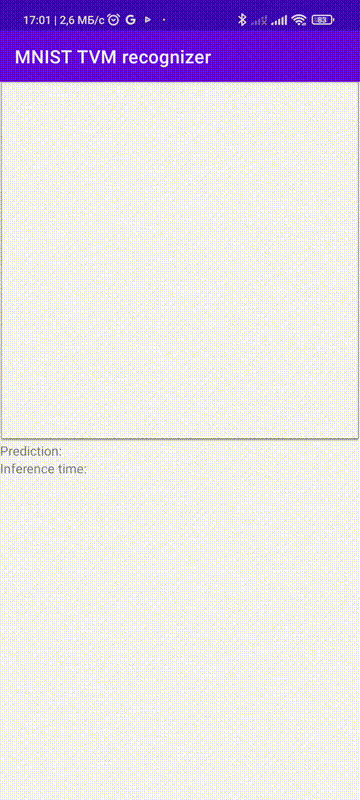

Ссылка на github: https://github.com/echuraev/MNIST-TVM-recognizer

Для демонстрации того, как можно интегрировать TVM в реальные приложения, реализуем простое приложение, которое будет определять рукописные цифры. На анимации выше представлен пример работы этого приложения.

## Основные компоненты приложения

- [PaintView](https://github.com/echuraev/MNIST-TVM-recognizer/blob/main/app/src/main/java/com/deelvin/mnist_tvm_recognizer/PaintView.java) - отвечает за рисование изображений.
- [TVM_MNIST_Helper](https://github.com/echuraev/MNIST-TVM-recognizer/blob/main/app/src/main/java/com/deelvin/mnist_tvm_recognizer/TVM_MNIST_Helper.java) - вспомогательный класс, отвечает за работу с TVM.
- [mnist_runner.cpp](https://github.com/echuraev/MNIST-TVM-recognizer/blob/main/app/src/main/cpp/mnist_runner.cpp) - реализация нативных функций, которые вызываются из Java.
- [TVMRunner.cpp](https://github.com/echuraev/MNIST-TVM-recognizer/blob/main/app/src/main/cpp/TVMRunner.h) - обёртка над TVM для запуска модели.
- [jniLibs](https://github.com/echuraev/MNIST-TVM-recognizer/tree/main/app/src/main/cpp/jniLibs) - библиотеки TVM Runtime и lib C++.
- [assets](https://github.com/echuraev/MNIST-TVM-recognizer/tree/main/app/src/main/assets) - библиотека со скомпилированной моделью.

Подробно разбирать то, как написано приложение не будем, исходный код можно найти на гитхаб, собрать и изучить, рассмотрим только основные компоненты.

## PaintView

- Определяет поле на котором можно рисовать.
- По быстрому нажатию 2 раза или когда с момента предыдущего рисования прошло более 5 секунд, очищает экран.
- Преобразовывает нарисованное изображение из высокого разрешения в картинку 28 на 28 пикселей и отправляет его на отображение в `MainActivity`.


Этот класс наследуется от [android.view.View](https://developer.android.com/reference/android/view/View) и в нём необходимо переопределить два метода: `onTouchEvent` - отвечает за обработку нажатия на экран и `onDraw`, который вызывается тогда, когда необходимо перерисовать содержимое PaintView. В `onTouchEvent` происходит обработка нажатий и запись линий, которые рисуются пальцем. Там же происходит обработка событий, когда необходимо очистить экран. Это происходит в двух случаях:
1. Когда пауза между рисованием была более 5 секунд.
2. Если быстро два раза нажать на `PainView`.

В момент, когда пользователь отпускает палец, нарисованное изображение приводится к размерам 28 на 28 пикселей и отображается на экране.

## TVM_MNIST_Helper

- Определяет основные константы: входные размеры + название модели.
- Определяет интерфейсы взяимодействия с нативным кодом.

В данном классе в константах определены размеры изображения и название файла с моделью, которая будет использоваться в приложении.

Класс включает в себя три метода:
1. `setModelPathAndInit` - передаёт в нативную часть путь до библиотеки с моделью и инициализирует модель.
2. `run` - принимает на вход массив, представляющий значения писелей, и запускает модель. По завершении возвращает предсказанное число в виде строки.
3. `getInferenceTime` - возвращает время последнего запуска модели.

## mnist_runner.cpp

- Реализует нативные функции, которые вызываются из Java.

В данном файле определена реализация нативных фукнций, которые вызываются из Java. `jni` объекты преобразуются в C++ и обратно. Вызываются методы из класса `TVMRunner`.

## TVMRunner.cpp

- Представляет паттерн Singleton.
- Предоставляет интерфейс для вызова функций из TVM.
- Содержит константу, определяющую на каком устройстве будет запускаться модель (CPU или GPU).

Класс `TVMRunner` реализован с использованием шаблона Singleton. Это сделано для того, чтобы при разных вызовах нативных функций, всегда использовалась одна и та же модель, и она инициализировалась только один раз.

Реализует упомянутые выше методы `setModelPathAndInit`, `run` и `getInferenceTime`. 

Метод `setModelPathAndInit` выбирает устройство на котором будет происходить запуск, создаёт `tvm::runtime::Module` из файла со скомпилированной моделью и получает необходимые методы из этого модуля. Устройство на котором будет происходить запуск выбирается строковой константой (`CPU` или `OpenCL`), определённой в анонимном пространстве имён. 

Метод `run` создаёт `tvm::runtime::NDArray` для входной картинки и перекладывает туда данные из `std::vector`. Затем этот тензор устанавливается в качестве входя для модели и модель запускается на исполнение. После завершения исполнения создаётся ещё один `NDArray`, где будет храниться результат исполнения модели. Данные копируются с устройства в этот тензор. В случае исполнения на `CPU` копирование можно не делать, а сразу использовать указатель на данные для тензора, что возвращается из функции `m_getOutputFunc`. После получения выходного тензора, находится индекс с максимальным значением. Это и есть предсказанная цифра.

Метод `getInferenceTime` однострочный и просто возвращает время последнего выполнения модели.

## jniLibs

- Содержит библиотеки TVM runtime и `libc++_shared` для каждой из архитектур.
- Нативная часть приложения линкуется с этими библиотеками.

Библиотеки `libc++_shared` были скопированны из Android NDK, а `libtvm_runtime` скомпилированы для каждой из архитектур с помощью кросс-компиляции. 

Эти библиотеки линкуются с нативной частью Android приложения. `libtvm_runtime` предоставляет эффективную среду выполнения и минимальный API для работы с TVM.

## Assets

- Содержит файлы со скомпилированной моделью под CPU и GPU.

Особенность asset'ов в том, что они находятся внутри apk файла и на Java мы можем открыть эти файлы только с использованием `AssetManager`. Из-за того, что в нативной части кода необходимо указать именно файл, содержащий скомпилированную модель, то в классе MainActivity есть небольшая хитрость. Во время запуска приложения файл с моделью вычитывается с помощью `AssetManager` и сохраняется в файл во временной директории. Затем этот файл используется для инициализации модели в нативном коде.

# Дополнительные примеры (приложение по удалению фона)

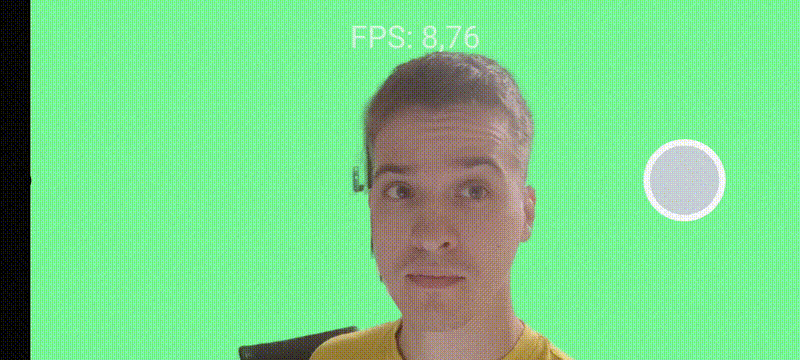

Ссылка на github: https://github.com/Deelvin/apache-tvm-tutorials/tree/master/RVM_Android_Demo

Это приложение позволяет удалить фон с камеры в режиме реального времени. Вы можете перейти по ссылке, построить приложение и запустить его на своём смартфоне. Для получения хорошей производительности необходим хороший GPU, т.к. модель тренировалась под Adreno 666.

# Заключение

## Полезные ссылки

- https://tvm.apache.org/docs/arch/debugger.html
- https://tvm.apache.org/docs/tutorial/tensor_expr_get_started.html
- https://tvm.apache.org/docs/dev/how_to/relay_bring_your_own_codegen.html
- https://tvm.apache.org/docs/how_to/deploy/adreno.html
- https://tvm.apache.org/docs/how_to/deploy_models/deploy_model_on_adreno.html

## Курсовой проект

### 1. Реализация приложения с использованием TVM
**Цель:** Написать полноценное приложение с использованием Apache TVM для инференса модели на целевом устройстве. Целевое устройство может быть любым - от микроконтроллера до сервера. Полная свобода творчества, единственное требование, что приложение должно использовать TVM, и модель должна быть настроена для достижения наилучшей производительности.

### 2. Заоптимизировать операцию Dense для Arm CPU
**Цель:** Расширить стратегию для неподдерживаемой операции и написать для неё расписание. Это не обязательно должен быть Dense для Arm CPU. Если в процессе работы с TVM вы встречали другую операцию, для которой не было написано расписание, то это может быть она (кроме conv2d_nhwc_x86). Расписание должно демонстрировать хороший прирост производительности. Критерий успеха - PR в репозиторий [Deelvin/tvm](https://github.com/Deelvin/tvm), который после местного ревью может быть так же создан в основной репозиторий TVM.

### 3. Добавить отсутствующую операцию в TVM
**Цель:** В случае, если во время экспериментов с TVM вы сталкивались с тем, что в TVM отсутствует какая-либо операция, то можно улучшить TVM добавив подобную операцию. Например, у Екатерины Волковой была проблема, что в модели был слой `keras.layers.Rescaling`, который не поддерживается в TVM на данный момент. Добавление слоя будет очень полезно с точки зрения поддержки моделей и весомым вкладом в сообщество. Результатом работы может быть PR в репозиторий [Deelvin/tvm](https://github.com/Deelvin/tvm), который после местного ревью может быть так же создан в основной репозиторий TVM.

### 4. Распределение задач на Arm CPU между big.LITTLE cores
**Цель:** На данный момент TVM старается работать только на больших ядрах. Распределение на малые ядра такого же объёма работы не целесообразно, т.к. они работают медленнее и больше времени будет тратиться на ожидание результата. Однако, можно поправить TVM runtime, чтобы распределять задачи было не равномерно, а с каким-то коэффициентом, например, малые ядра будут выполнять менший объём вычислений, чем большие. Таким образом возможно удастся снизить нагрузку на большие ядра и увеличить скорость инференса.

## Ссылка на доклад

- https://github.com/Deelvin/apache-tvm-tutorials/blob/master/Neimark/Day%202/Neimark.%20TVM%20Presentation.%20Day%202.ipynb

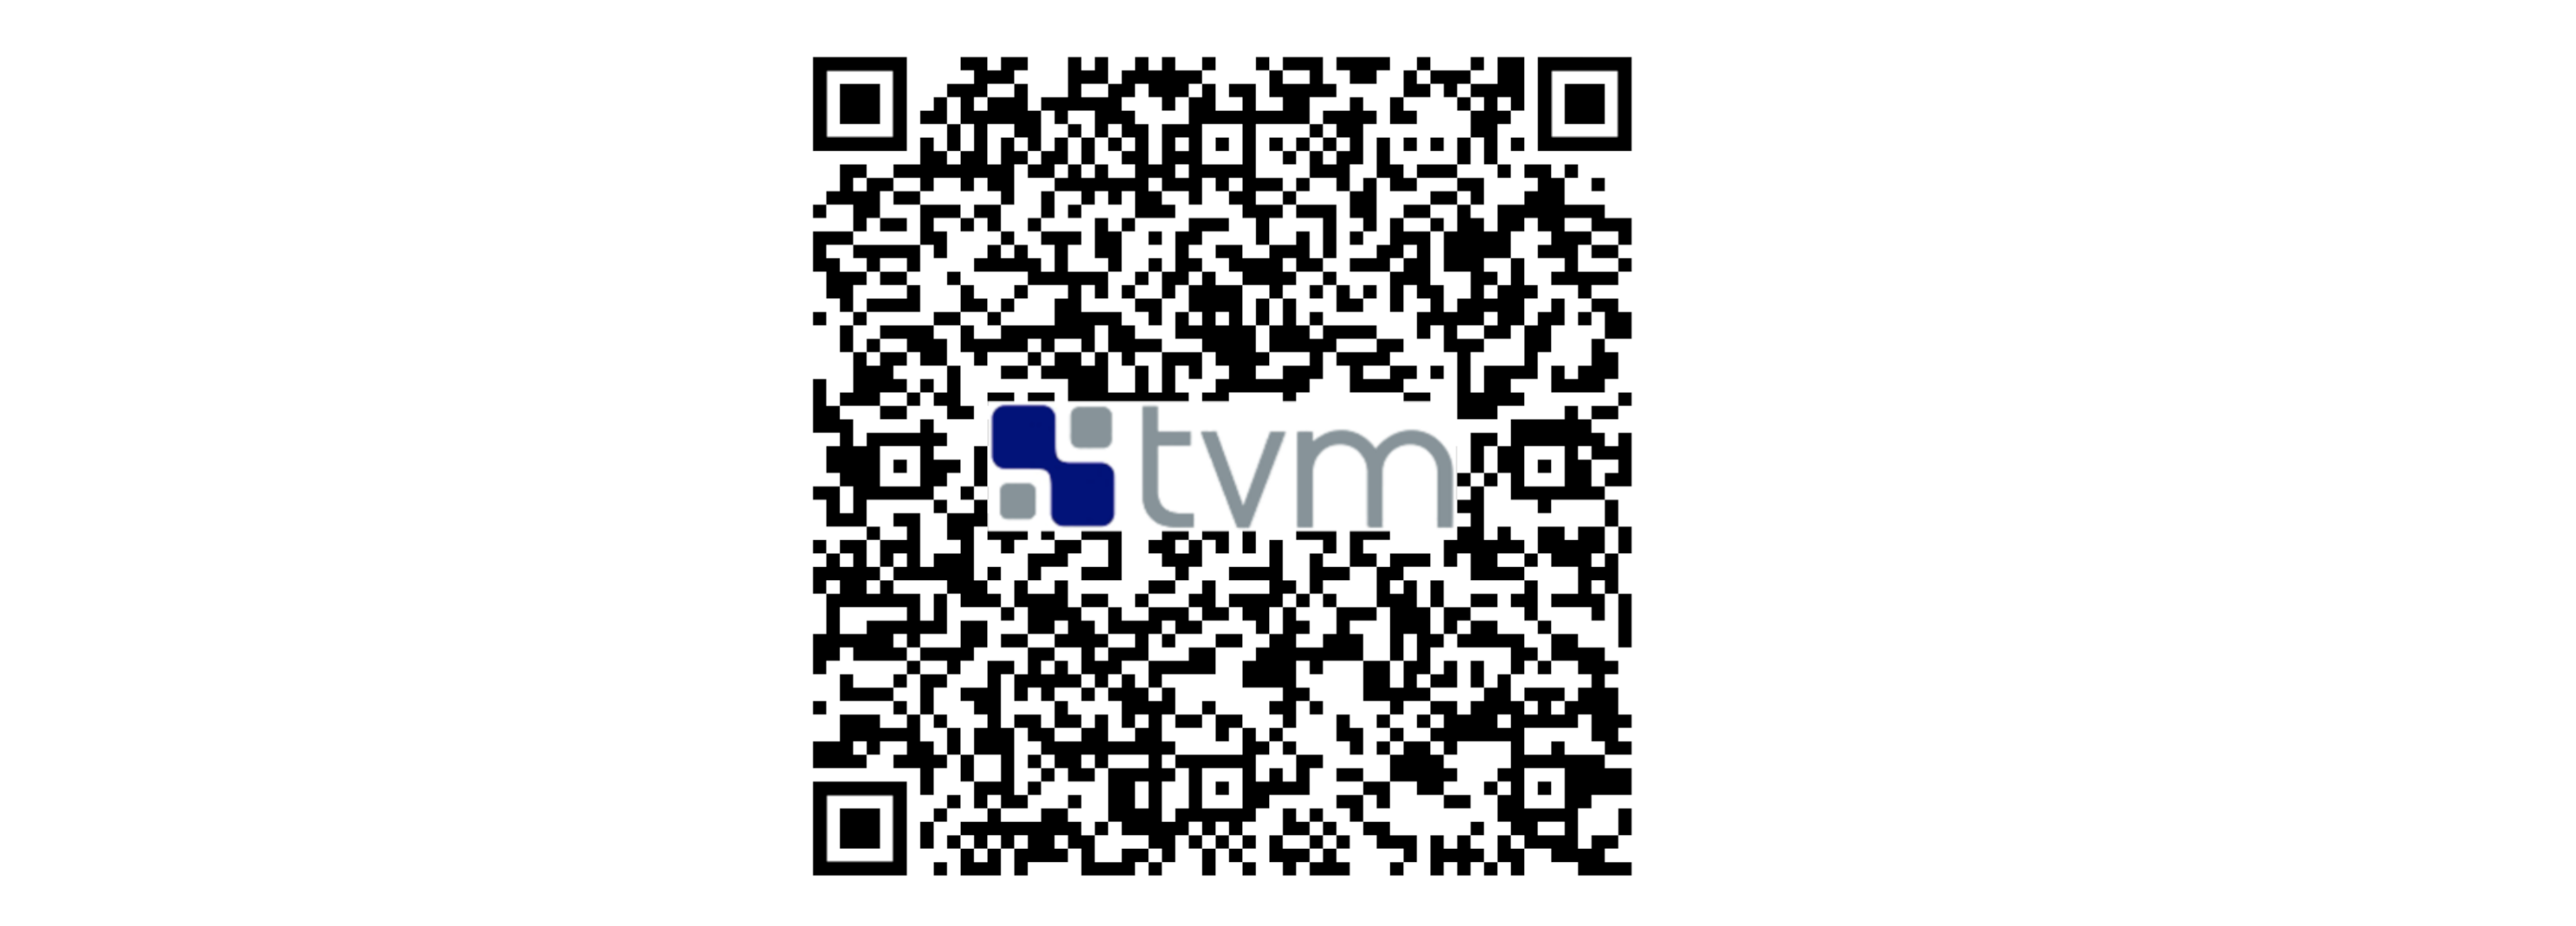

# Спасибо за внимание!

email: egor.churaev@deelvin.com / echuraev@hse.ru

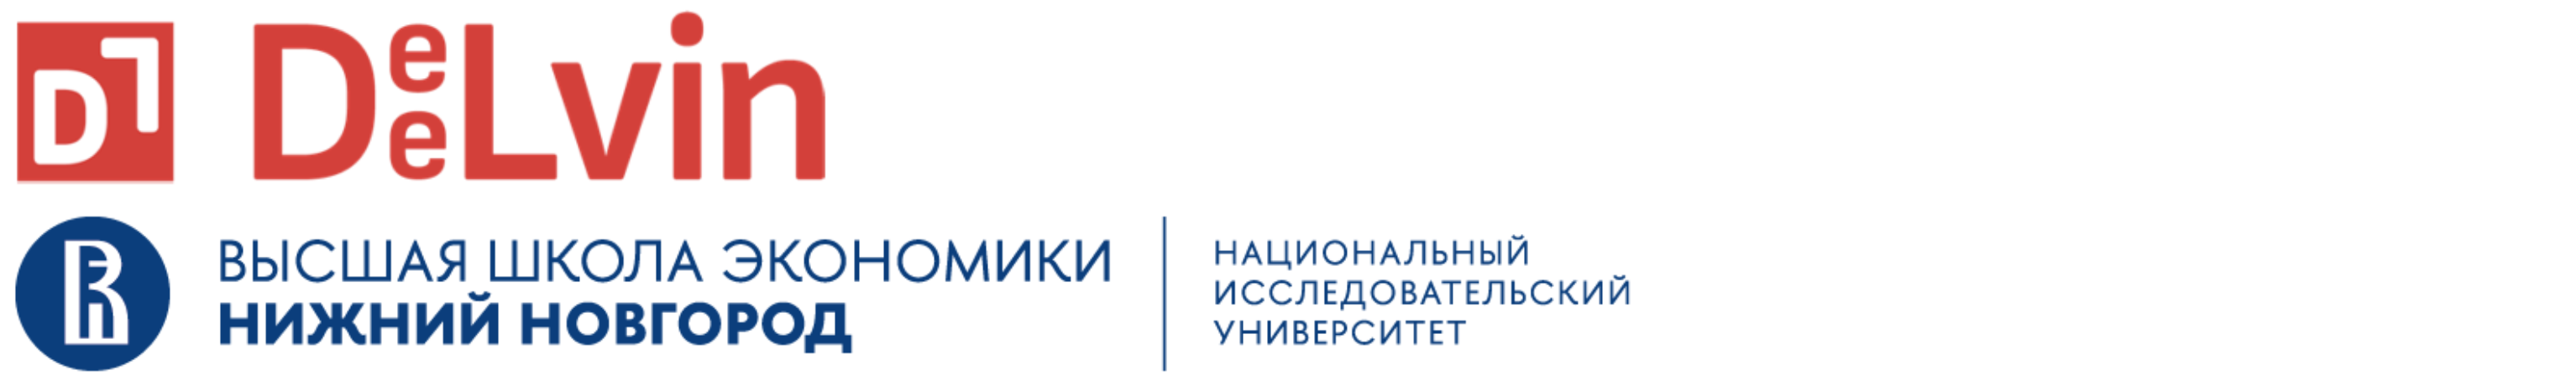